In [ ]:
#This mounts the google drive to the Colab VM
from google.colab import drive
drive.mount('/content/drive')

#This is the name of the folder where the ipynb file
FOLDERNAME = 'IEA Proj 2/notebooks'

#Here, we're adding the folder to the path
import sys
sys.path.append("/content/drive/My Drive/{}".format(FOLDERNAME))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/IEA Proj 2/notebooks"

[Errno 2] No such file or directory: '/content/drive/My Drive/IEA Proj 2/notebooks'
/content


# Introduction

In this project, we will build a **note-taking mobile application**. In this application, the user will be able to:

1. Create, edit, and rename different note pages
2. Type notes, as all regular note-taking applications allow
3. Write the notes using the phone's touchscreen

A screenshot of the design of the app can be seen below:

<img src="https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/blob/main/images/app_screenshot.jfif?raw=true" width="200" />

The **main objective** of this notebook **is to document** the development of the third feature, writing the notes using the phone's touchscreen. For this feature, the application will have to use a **Machine Learning model to analyze and identify the hand-written words/digits** that the user wrote, in order to then convert them to text.
![Image](https://miro.medium.com/max/1400/1*4TJWlK-FPhskEIJshfEx5g.jpeg)

As such, the flow of the project is as follows:

1. **[Data Preparation](#data_preparation)**: In this section, we describe, and clean the datasets used for model training

2. **[Preprocessing](#preprocessing)**: In this section, we define the preprocessing that needs to be done on input data before feeding it to the model

3. **[Modelling](#modelling)**: In this section, we build different models and evaluate each in order to come up with a final choice on which model to adopt in our application

4. **[Deployment](#deployment)**: In this section, we discuss how the model was deployed and interfaced with the built mobile application

5. **[Conclusion](#conclusion)**: In this section, we conclude the project

# Data Preparation
<a id='data_preparation'></a>

We first began by cleaning the dataset that was used in project 1, which can be found by following this link: https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset

26 images presenting clear anomalies were removed from the dataset, as these images will most probably hinder the performance of the learning agent. The most obvious anomalies were images with dots for letters that should not have dots. These are shown below:

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

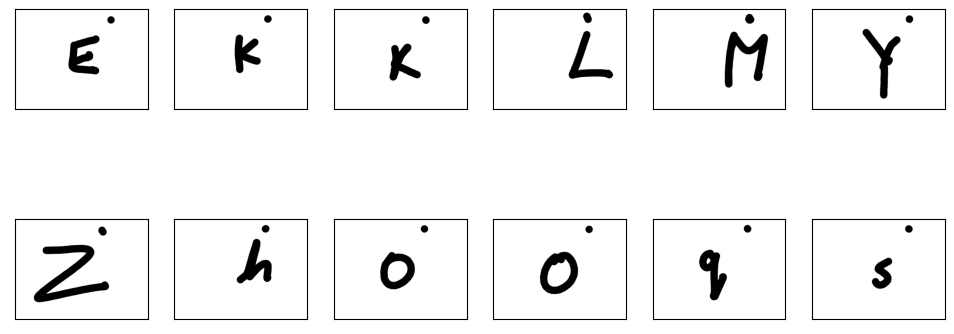

In [3]:
path = "../input/deleted_images/Dataset1"
dir = ['/img015-007.png', '/img021-005.png', '/img021-046.png', '/img022-049.png', '/img023-049.png', '/img035-037.png', 
       '/img036-004.png', '/img044-048.png', '/img051-004.png', '/img051-009.png', '/img053-015.png', '/img055-017.png']
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

i = 1
for d in dir:
    plt.subplot(2,6,i)
    img = mpimg.imread(path + d)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i = i+1

The other images that were deleted were either the only letter written in cursive out of 55 instances, or they were images that do not look like their label. These are shown below:

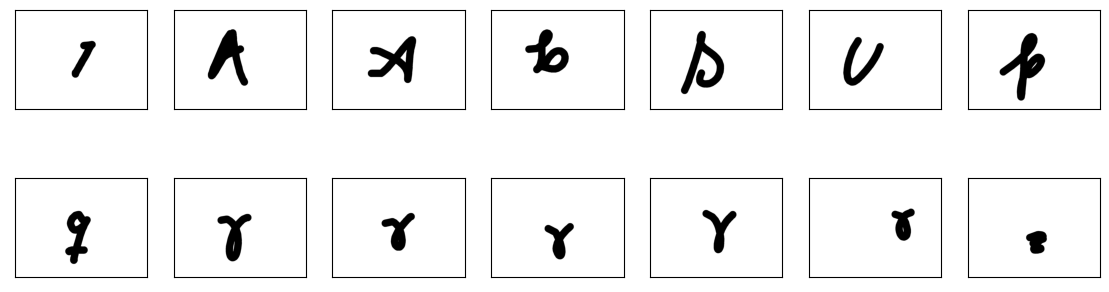

In [4]:
dir = ['/img008-029.png', '/img011-004.png', '/img011-027.png', '/img022-055.png', '/img029-055.png', '/img031-053.png',
       '/img052-044.png', '/img053-053.png', '/img054-010.png', '/img054-012.png', '/img054-025.png', '/img054-042.png',
      '/img054-049.png', '/img062-036.png']
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(4)

i = 1
for d in dir:
    plt.subplot(2,7,i)
    img = mpimg.imread(path + d)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i = i+1

Since we will be using parametric learners, namely Neural Networks, it was imperative that we expand the dataset. So, we downloaded another alphanumeric dataset from Kaggle using the following link: https://www.kaggle.com/datasets/hrishabhtiwari/handwritten-digits-and-english-characters

Similarly to the first one, this dataset needed cleaning. We deleted 41 images, of which we will present the most flagrant:

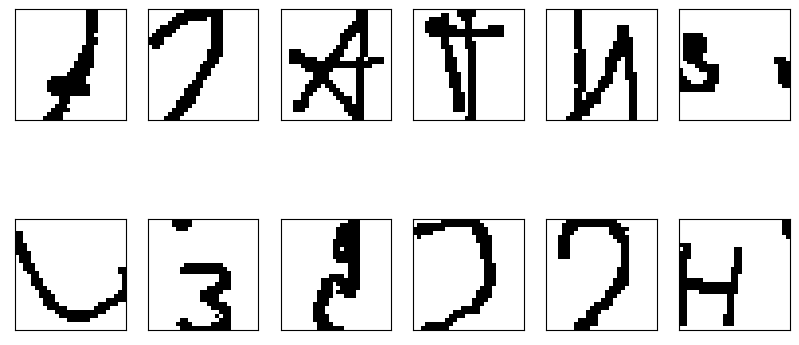

In [5]:
path = "../input/deleted_images/Dataset2"
dir = ['/377.png', '/266.png', '/529.png', '/1094.png', '/1117.png', '/2014.png', '/2108.png', '/2776.png', '/3701.png',
       '/2629.png', '/2670.png', '/1093.png']
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

i = 1
for d in dir:
    plt.subplot(2,6,i)
    img = mpimg.imread(path + d)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i = i+1

After cleaning the datasets and combining them, we studied the frequency of each label to make sure that the data is not biased towards a group of labels. This step is crucial to ensure that the dataset is evenly distributed over the labels.



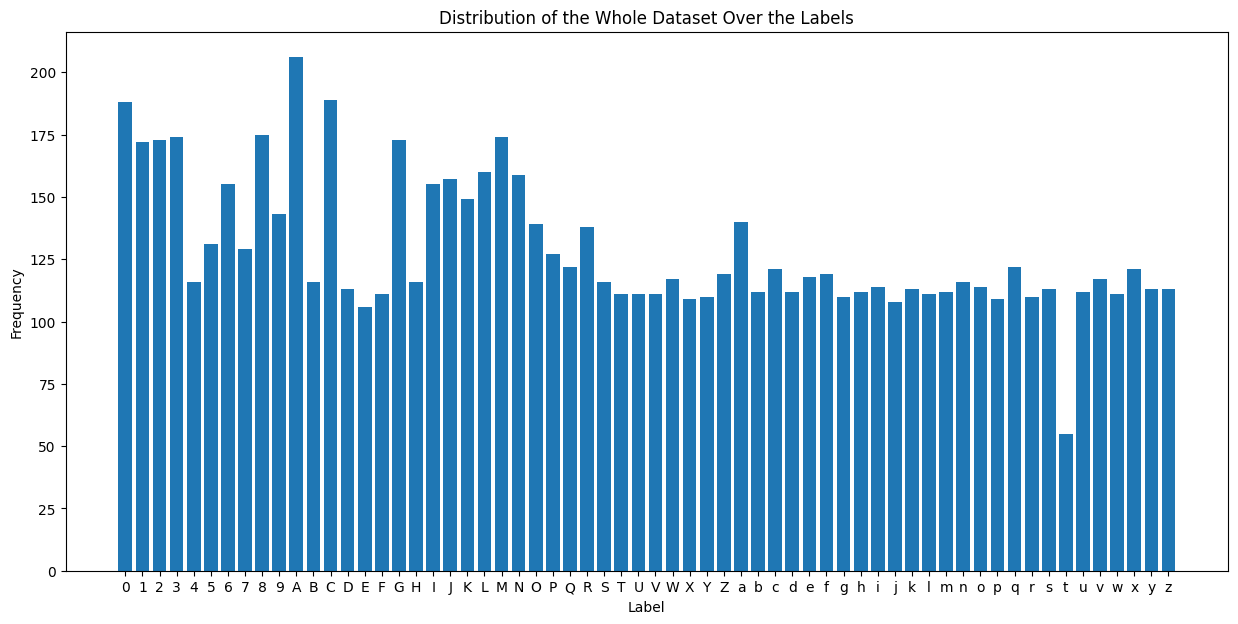

In [8]:
df = pd.read_csv('../input/english.csv')
labelfreq = df["label"].value_counts().sort_index()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
plt.bar(labelfreq.index, labelfreq)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of the Whole Dataset Over the Labels')
plt.show()

# Preprocessing <a id='preprocessing'></a>

As an initial step, we need to find a way to extract the character from the image. 

To do so, we can use OpenCV's contour function to write a function that gets the bounding box around a certain character in an image. 

In [9]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools

In [10]:
def get_bounding_box(input_dir, fname, output_directory="", write=False):
    """
    Extracts the letter from an image by getting bounding boxes and resizes 
    the photo to 40x30x3 (RGB color stays)

    Parameters
    ----------
    input_dir : string
        Directory that contains the file to be analyzed (excluding the name of the file).
    fname : string
        The name of the file to be analyzed.
    output_directory : string
        Directory where the resulting file should be saved.
    show : boolean, optional
        Displays the image using OpenCV if True. The default is False.

    Returns
    -------
    ndarray
        Original image with bounding boxes applied on it.
    letter_imgs : list
        List of cropped images from the bounding boxes.
        
    """

    image = cv2.imread(f"{input_dir}/{fname}")
    original = image.copy()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    bounding_rects = [cv2.boundingRect(c) for c in cnts]

    letter_imgs = []

    for index, (x, y, w, h) in enumerate(bounding_rects):
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

        t, imbw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        ROI = original[y:y + h, x:x + w]
        imbw = imbw[y:y + h, x:x + w]
        ROI = cv2.resize(ROI, (40, 30), interpolation=cv2.INTER_CUBIC)[:, :, 0]
        imbw = cv2.resize(imbw, (40, 30), interpolation=cv2.INTER_CUBIC)

        letter_imgs.append(imbw)

        if write:
            ext_pos = fname.rfind(".")
            file_name = fname[:ext_pos] + f"_{index}" + fname[ext_pos:]
            cv2.imwrite(f'{output_directory}/{file_name}', imbw)

    return (image[:, :, ::-1], letter_imgs)

Let's test it out:

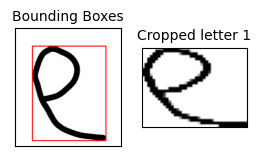

In [11]:
image_with_boxes, cropped = get_bounding_box("../src/test_images",
                                             "test_0.jpg",
                                             "../src/test_images/results")
plt.figure(figsize=(3, 3))

plt.subplot(1, len(cropped) + 1, 1)
plt.imshow(image_with_boxes)
plt.title("Bounding Boxes", fontsize=10)
plt.xticks([])
plt.yticks([])

for i, letter in enumerate(cropped):
    plt.subplot(1, len(cropped) + 1, i + 2)
    plt.imshow(letter, cmap="gray")
    plt.title(f"Cropped letter {i+1}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

The above algorithm can also detect multiple letters in the same image:

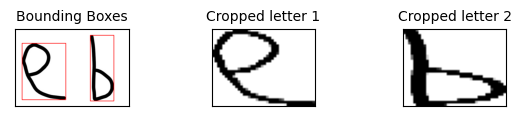

In [12]:
image_with_boxes, cropped = get_bounding_box("../src/test_images",
                                             "test_01.jpg")

plt.figure(figsize=(7, 1))

plt.subplot(1, len(cropped) + 1, 1)
plt.imshow(image_with_boxes)
plt.title("Bounding Boxes", fontsize=10)
plt.xticks([])
plt.yticks([])

for i, letter in enumerate(cropped):
    plt.subplot(1, len(cropped) + 1, i + 2)
    plt.imshow(letter, cmap="gray")
    plt.title(f"Cropped letter {i+1}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

However, as used now, the algorithm might generate undesired results. For instance, when writing the letter A, the user might draw it in such a way that the dash connecting the two sides might not intersect them. In this case, the algorithm would detect two objects, instead of one connected A. This case is also seen with letters that take in a *dot*, such as the 'i' or the 'j'. Below is an example:

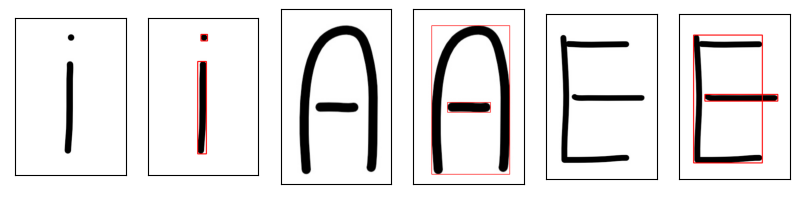

In [13]:
i, _ = get_bounding_box("./images", fname="letter_i.jpg")
A, _ = get_bounding_box("./images", fname="letter_A.jpg")
E, _ = get_bounding_box("./images", fname="letter_E.jpg")
i1 = matplotlib.image.imread("./images/letter_i.jpg")
A1 = matplotlib.image.imread("./images/letter_A.jpg")
E1 = matplotlib.image.imread("./images/letter_E.jpg")
to_show = [(i1, i), (A1, A), (E1, E)]

plt.figure(figsize=(10, 5))
i = 1
for letter, bounded_letter in to_show:
    plt.subplot(1, 6, i)
    plt.imshow(letter)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 6, i + 1)
    plt.imshow(bounded_letter)
    plt.xticks([])
    plt.yticks([])
    i += 2

Therefore, we must alter the traditional functionality to take into account such instances.

In order to do so, we will define a function called *merge_near* that cycles through the boxes and merges those that fall under certain conditions. Mainly, we have 3 relative position:

1. One box is fully contained within the other. this is like the example of the letter 'A'
2. The two boxes overlap, with either one starting within the other and ending out of it, or vice versa.
3. Both boxes are separate with no overlap                                                

To be able to distinguish the cases, we will use a certain *threshold* that defines a radius of proximity for both the horizontal dimension and the vertical dimension. In our case, we want to merge the boxes if:
1. They're fully contained within each other
2. They're partially contained within each other, such that the distance between the extremiites of one and the other falls within the aforementioned threshold.

In [14]:
def merge_near(boxes, hor_threshold=10, ver_threshold=10, merge_dots = False):
    """
    Takes a list of bounding boxes and merges those that are either fully 
    contained within other, within a certain radius of each other, 
    
    Parameters
    ----------
    boxes : list
        Original list of bounding boxes.

    hor_threshold : int, optional
        The horziontal threshold with which to consider two boxes near each 
        other. Basically, defines the horizontal radius. The default is 10.
    ver_threshold : int, optional
        The vertical threshold with which to consider two boxes near each 
        other. Basically, defined the vertical radius. The default is 10.
    merge_dots : bool, optional
        Flag to signal if we're merging dots usual shapes. This is done
        because dots need a different vertical threshold than the normal 
        shapes. The default is False.

    Returns
    -------
    list
        Updated list with merged boxes.

    """

    #Final list that is returned
    prev = boxes.copy()      
    
    changed = True
    merged_boxes = set({})
    
    #As long as changes are being made, keep on looping through the list
    while changed == True:              
        
        changed = False
        updated = []

        #If we are checking dots, filter the list for dots only
        if merge_dots:
            dots = [(x,y,w,h) for x,y,w,h in prev if w<140 and h<140]
            combinations = list(itertools.product(prev, dots))
        else:
            combinations = list(itertools.product(prev, prev))
            
        combinations = [e for e in combinations if e[0] != e[1]]
        
        #Loop through the boxes in the list -that includes the merged boxes-
        for pos, ((x1, y1, w1, h1), (x2, y2, w2, h2)) in enumerate(combinations):   
            
            #If a change was made, break out of the loop to do another iteration
            if changed == False:
                #Calculate different relative positions
                #You have 3 cases:  Fully contained within each other
                #                   Starts inside, ends outside / starts outside, ends inside
                #                   Starts outside, ends outside                                                
                #Note that we don't have the starting outside and ending inside because it is the same but different perspective, which we account for                                      
                
                #We want to merge if:   Fully contained 
                #                       Starts within ends outside, provided other dimension's difference is within threshold
                #                       Starts outside ends outside, provided both dimensions' differences are within threshold
                #Note that, while the difference might catch the starts inside, it is bounded by the threshold. So if the second rect starts within but is much larger, the difference in extremities will be > threshold. However, we still want to merge
                
                is_start_contained_hor = (x2 < x1 + w1 and x2 > x1)
                is_start_contained_ver = (y2 < y1 + h1 and y2 > y1)
                is_end_contained_hor = (x2 + w2 < x1 + w1 and x2 + w2 > x1)
                is_end_contained_ver = (y2 + h2 < y1 + h1 and y2 + h2> y1)
                is_contained = is_start_contained_hor and is_start_contained_ver and is_end_contained_hor and is_end_contained_ver
                are_extremities_threshold_hor = np.abs(x2 + w2 - x1) < hor_threshold or np.abs(x1 + w1 - x2) < hor_threshold
                are_extremities_threshold_ver = np.abs(y2 + h2 - y1) < ver_threshold or np.abs(y1 + h1 - y2) < ver_threshold
                
                if (is_contained or (
                        is_start_contained_hor and are_extremities_threshold_ver) or (
                            is_start_contained_ver and are_extremities_threshold_hor) or (
                                are_extremities_threshold_ver and are_extremities_threshold_hor)):
                    
                
                    
                    
                    #Note down the updated coordinates of the merged boxes
                    updated_x = min(x1,x2)
                    updated_y = min(y1,y2)
                    #Update the widths and height by getting final point - start point
                    updated_w = max(x1+w1, x2+w2) - updated_x
                    updated_h = max(y1+h1, y2+h2) - updated_y
                    
                    updated.append((updated_x, updated_y, updated_w, updated_h))
                    
                    merged_boxes.add((x1,y1,w1,h1))
                    merged_boxes.add((x2,y2,w2,h2))
                    
                    changed = True
                    
                    #Add all other boxes to updated for rerun
                    for box in boxes:
                        if box not in merged_boxes:
                            updated.append(box)
                    prev = updated
        
            else:
                break

    return prev if prev else boxes 

We also define an updated version of *get_bounding_boxes* that takes the merging into consideration:

In [15]:
def get_bounding_box(input_dir, fname, output_directory="", merge=True):
    """
    Extracts the letter from an image by getting bounding boxes and resizes 
    the photo to 40x30x3 (RGB color stays)

    Parameters
    ----------
    input_dir : string
        Directory that contains the file to be analyzed (excluding the name of the file).
    fname : string
        The name of the file to be analyzed.
    output_directory : string, optional
        Directory where the resulting file should be saved. If not present,
        no file is saved. The default is "".
    merge : bool, optional
        Flag to decide whether to run the merge algorithm or not. The default 
        is True.

    Returns
    -------
    ndarray
        Original image with bounding boxes applied on it.
    letter_imgs : list
        List of cropped images from the bounding boxes.

    """
        
        
    image = cv2.imread(f"{input_dir}/{fname}")
    original = image.copy()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 
    
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    bounding_rects = [cv2.boundingRect(c) for c in cnts]
    
    
    #Run the merge algorithm twice: once to catch the dots, and once for the others
    if merge:
        bounding_rects = merge_near(bounding_rects, hor_threshold=5, ver_threshold=100, merge_dots=True)    
        bounding_rects = merge_near(bounding_rects, hor_threshold=5, ver_threshold=10)
    
    
    letter_imgs = []
    
    for index, (x,y,w,h) in enumerate(bounding_rects):    
        cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
        
        
        t, imbw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        ROI = original[y:y+h, x:x+w]
        imbw = imbw[y:y+h, x:x+w]
        ROI = cv2.resize(ROI, (28, 28), interpolation = cv2.INTER_CUBIC)[:,:,0]
        imbw = cv2.resize(imbw, (28, 28), interpolation = cv2.INTER_CUBIC)
        
        letter_imgs.append(imbw)

        if output_directory:
            ext_pos = fname.rfind(".")
            file_name = fname[:ext_pos] + f"_{index}" + fname[ext_pos:]
            cv2.imwrite(f'{output_directory}/{file_name}', imbw)
            
    
    return (image[:,:,::-1], letter_imgs)

We can test the function on different inputs to see how it differs from the original one.

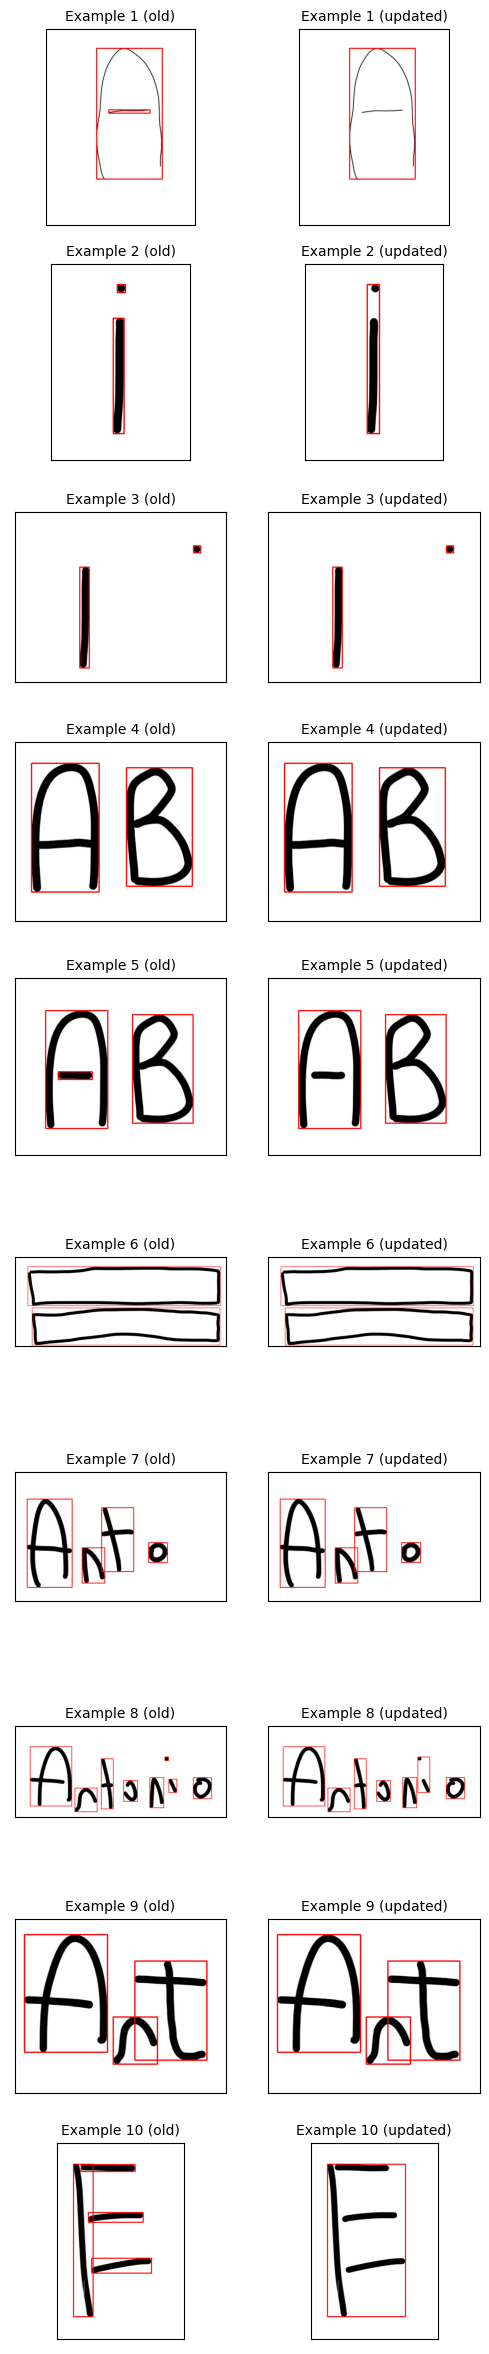

In [16]:
plt.figure(figsize=(6, 30))

s = 1
for i in range(1, 11):
    fname = f"test_{i}.jpg"

    plt.subplot(10, 2, s)
    old, _ = get_bounding_box("../src/test_images", fname, merge=False)
    plt.imshow(old)
    plt.title(f"Example {i} (old)", fontsize=10)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(10, 2, s + 1)
    im, _ = get_bounding_box("../src/test_images", fname, merge=True)
    plt.imshow(im)
    plt.title(f"Example {i} (updated)", fontsize=10)
    plt.xticks([])
    plt.yticks([])

    s += 2

We can see that the bounding boxes are created as required, with dots, neighboring boxes, and contained boxes being merged with their respective parents/neighbors.

# Modelling <a id='modelling'></a>

After having processed the input into an array that represents a cropped version of the letter, we need to build a model that will recognize the handwritten digit/character.

We will build several models, and for each, we will report the model's accuracy, precision, recall, and F-Value, as well as providing the model's confusion matrix.

We will be building four main models before combining some of them in an ensemble to create an even better model:

1. [Random Forest](#random_forest)
2. [Neural Network (Built from Scratch)](#nn_scratch)
3. [Neural Network (using Tensorflow)](#nn_tensorflow)
4. [Convolutional Neural Network (using Tensorflow)](#cnn)
5. [Transfer Learning](#transfer_learning)

## Random Forest <a id='random_forest'></a>

### Introduction

For staters, we decided to test the character recognition using non-parametric learners.
Non-Parametric machine learning models aim to fit the data without taking any assumptions and without tuning any parameters. They are relatively easy to use since they do not require any training (the training is the data itself).

Non-parametric models have both pros and cons:

* **Pros:**
> * Capability to fit multiple functions
> * No assumption about the underlying function
> * Can result in better results for certain applications

* **Cons:**
> * Requires more data
> * Slower 'train' because it loops over the entire dataset
> * Bad data could result in bad results

The analysis of different parameteric models was conducted in a separate notebook. Out of all these models, the Random Forest achieved the best accuracy. For details, refer to [this notebook](https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/blob/main/Testing_Models.ipynb).

For ease of reference, the results and accuracies of the model are listed below:

* k-NN (1): 66.9% accurate
* k-NN (2): 66.5& accurate
* SVM: 72.5% accurate
* Decision Tree: 58.4% accurate
* **Random Forest: 77.8% accurate**
* Ensemble of the above: 73.9% accurate


To understand Random forest, we should first briefly go over normal Decision Trees. 

A decision tree is a flowchart-tree structures that helps predicting and classifying objects. Each node in the tree is an attribute and the branches represent the outcomes of the nodes. To further understand the decision tree, we take this picture as example:
![Image](https://miro.medium.com/max/640/1*LMoJmXCsQlciGTEyoSN39g.webp)

In this tree, we are identifying the numbers, wether they are red and underlined.

Now going back to random forests, they are a collection of decision trees that operates as an ensemble where the output that is predicted by the most trees in this forest will be the output of the entire ensemble.

### Codes

We first imported the needed libraries from python

In [48]:
import sys
sys.path.append('../') 
sys.path.append('../src') 
import time
import joblib
import pandas as pd
from src.features import profiles
from src.features import per_Pixel
from src.features import intersections
from src.features import getHistograms
from src.features import invariantMoments
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_recall_fscore_support
from src.pre_processing_old import get_bounding_box as get_old_boxes

We then divide our dataset into training (80%) and testing (20%) sets

In [49]:
"""
Dataset Path to be changed accordingly
"""
dataset_path = '../input/original_images'

df = pd.read_csv('../input/english.csv')
    
# 80% of the data is selected for training
train_df = df.sample(frac=0.80, random_state=0)
 
# drop the training data from the original dataframe
test_df = df.drop(train_df.index)

To prepate the training and testing data we get the features needed for the predictions and train on them. We are using the following features:

*   Profiles
*   Histogram
*   Invariant Moments
*   Intersections
*   Pixel Densities



Preparing Data: Started


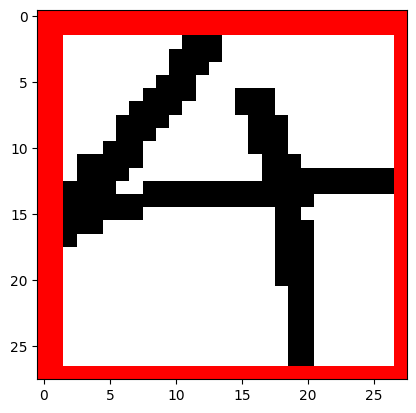

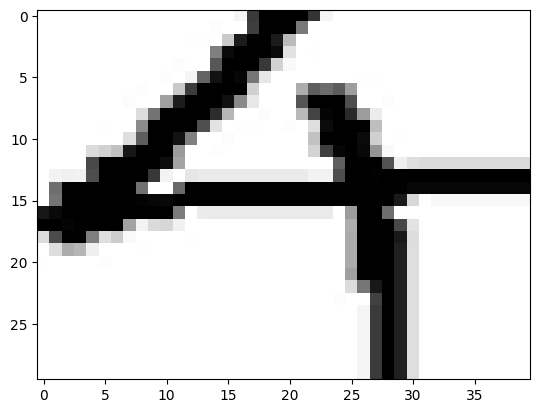

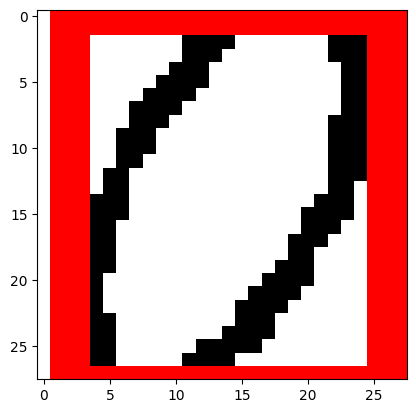

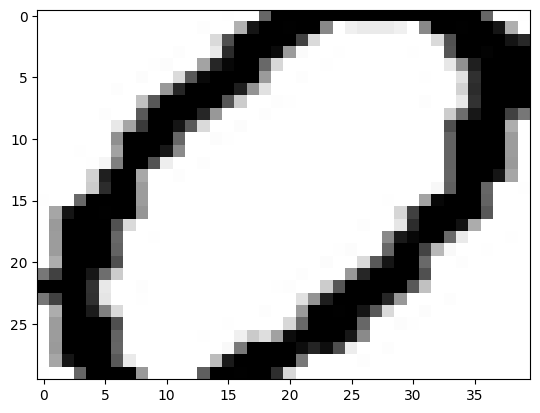

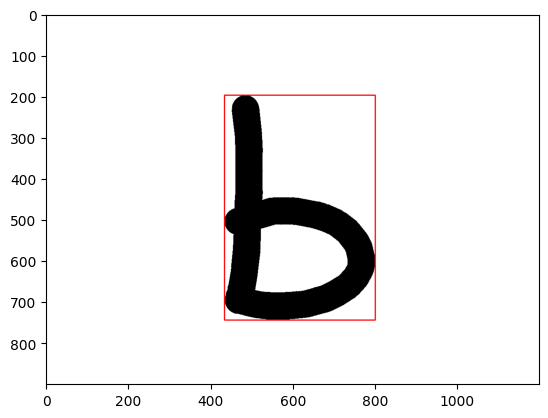

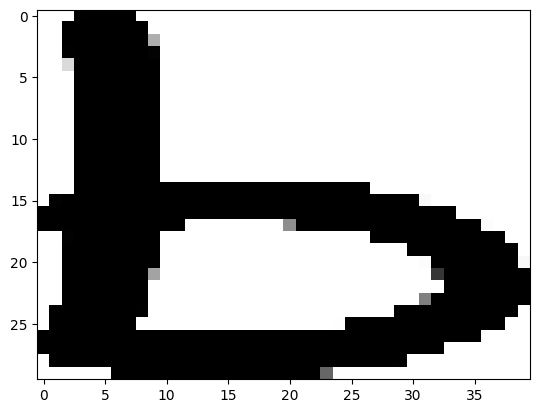

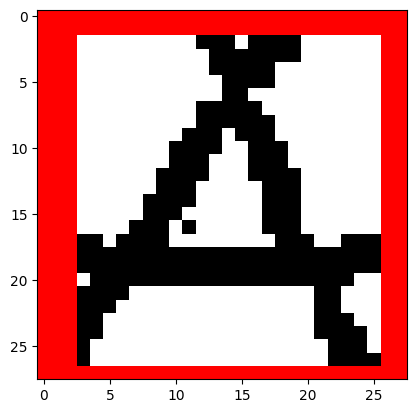

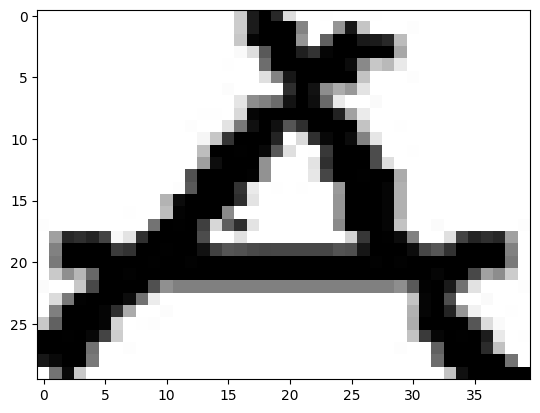

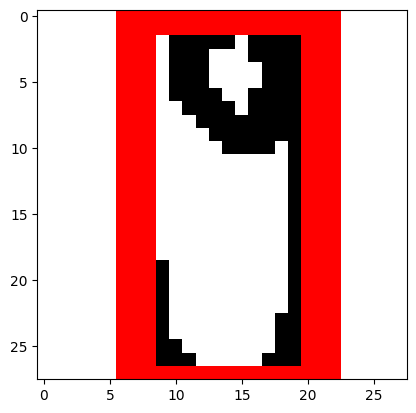

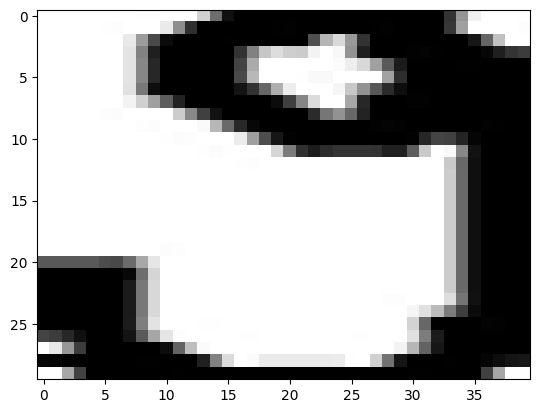

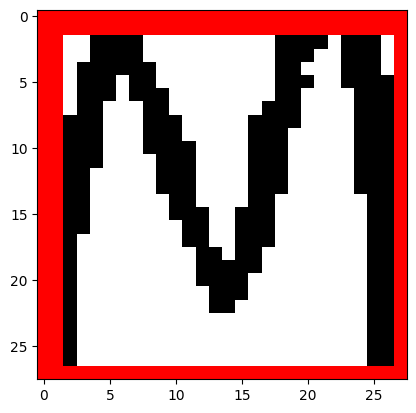

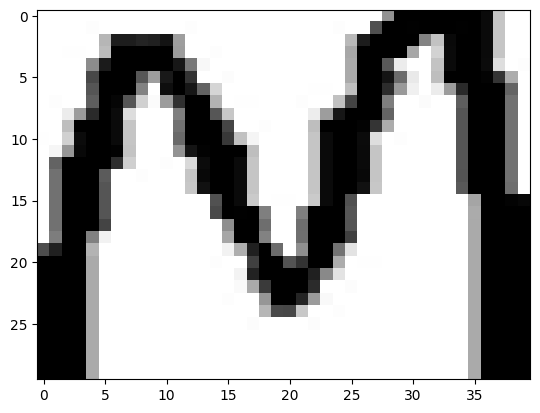

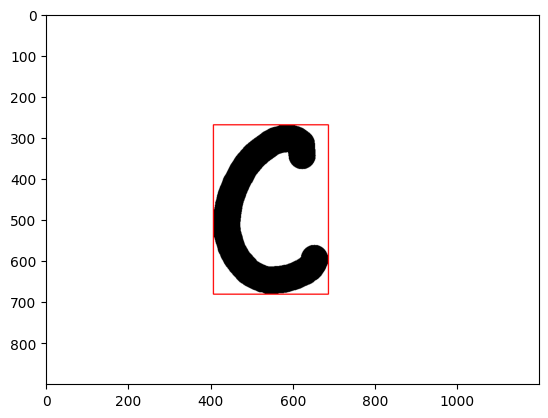

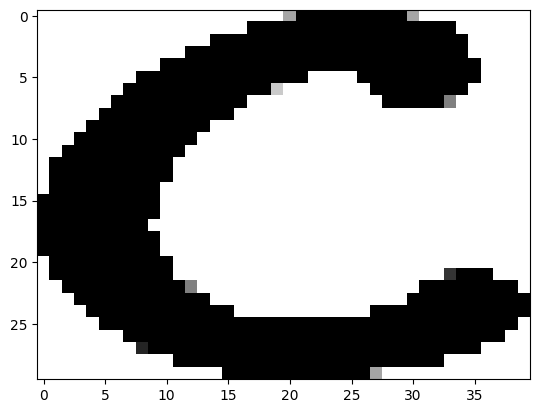

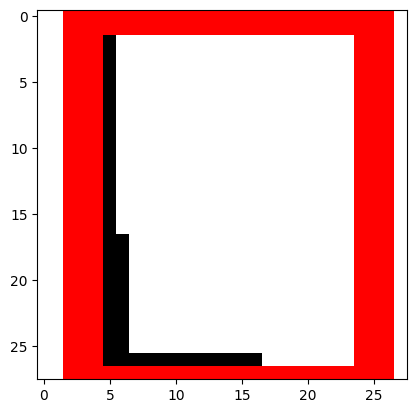

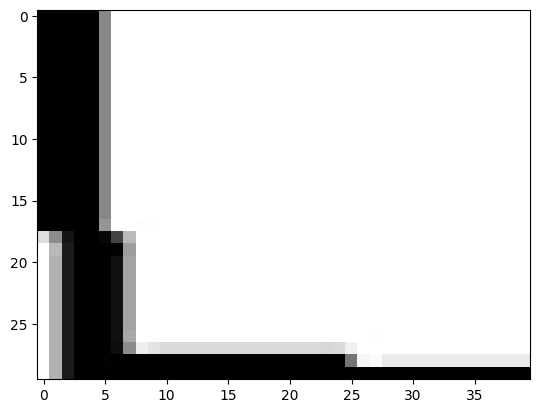

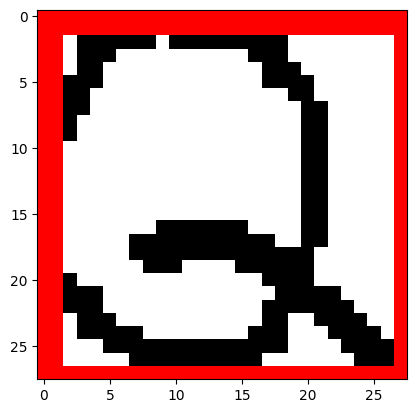

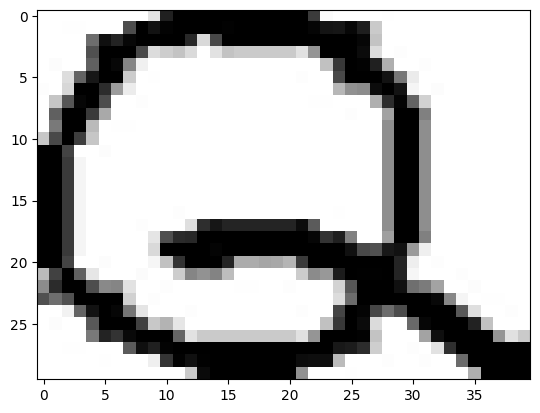

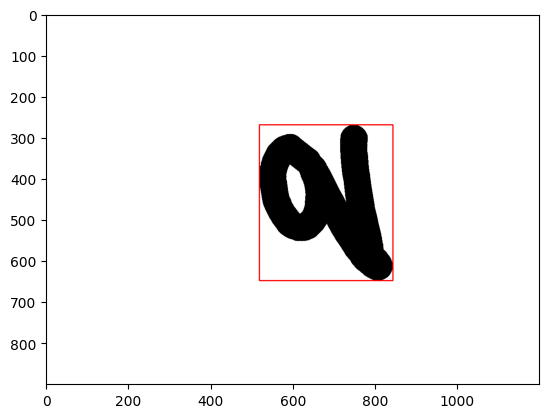

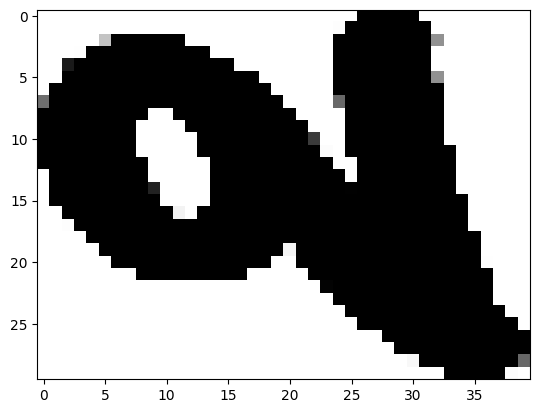

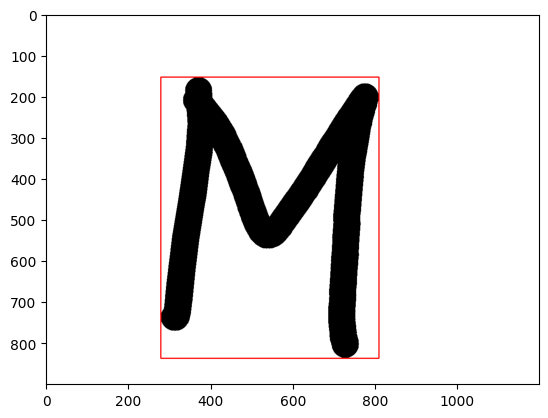

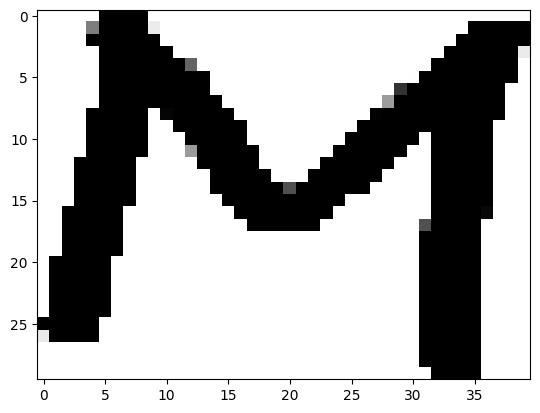

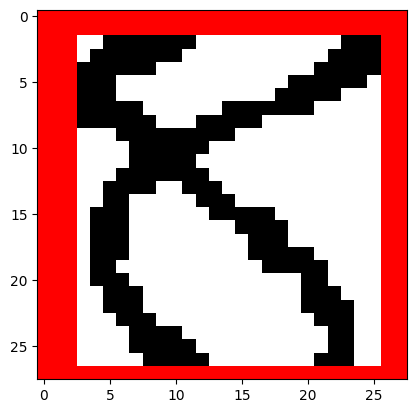

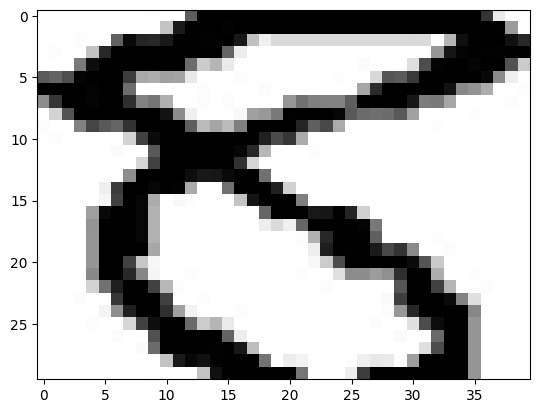

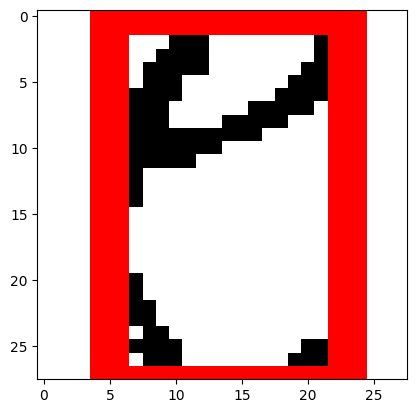

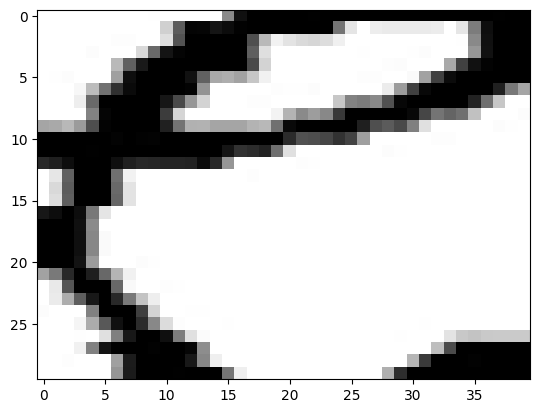

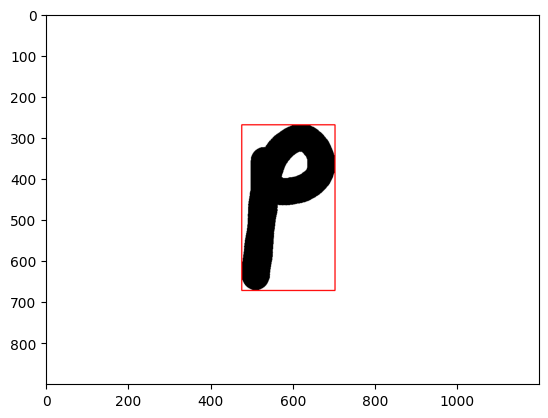

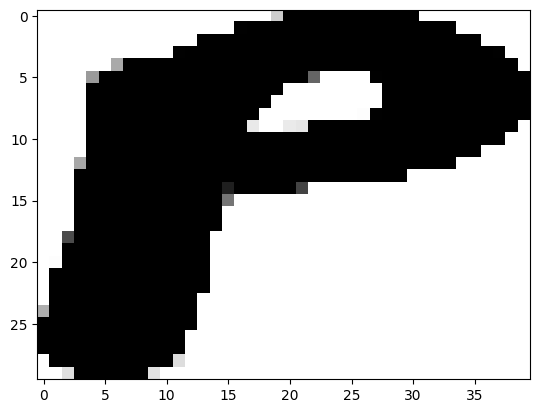

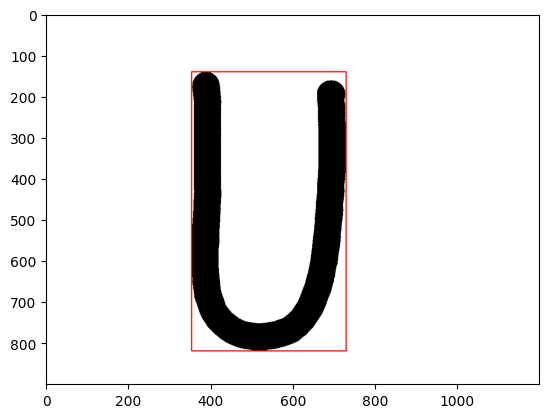

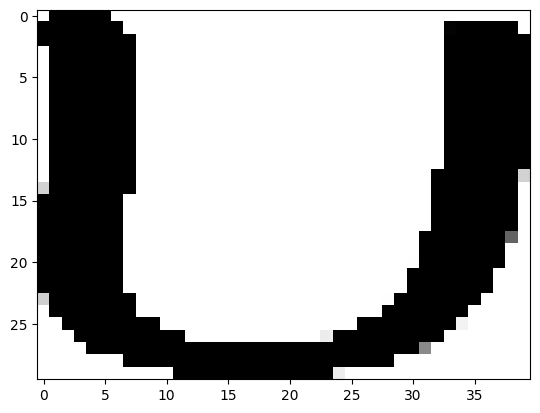

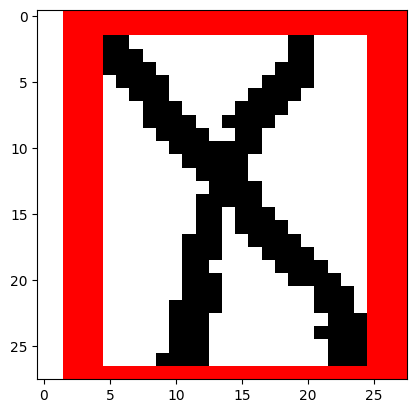

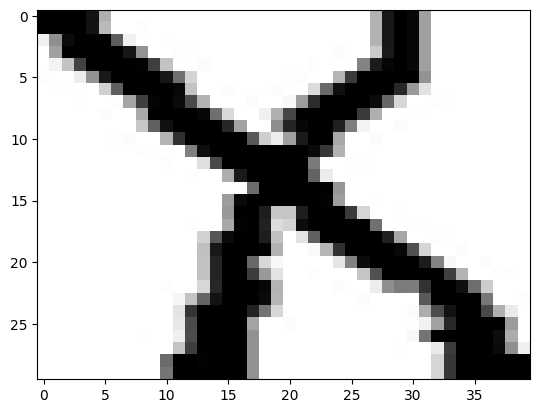

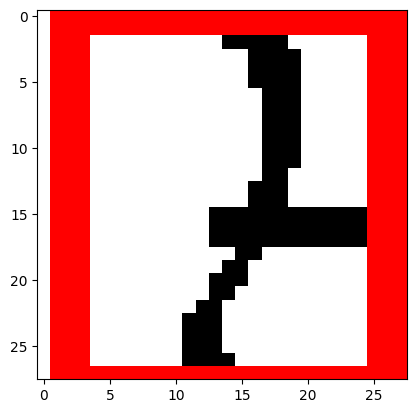

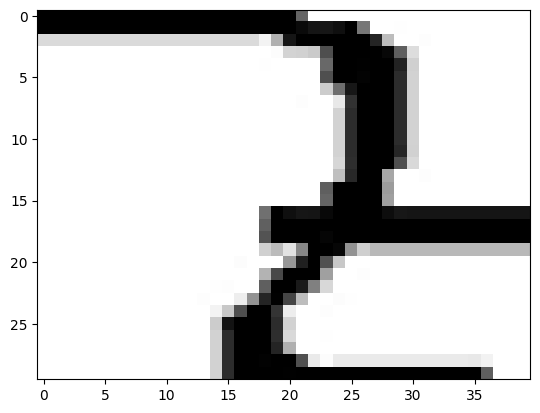

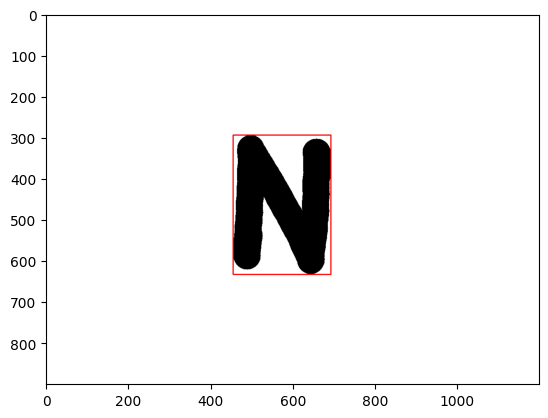

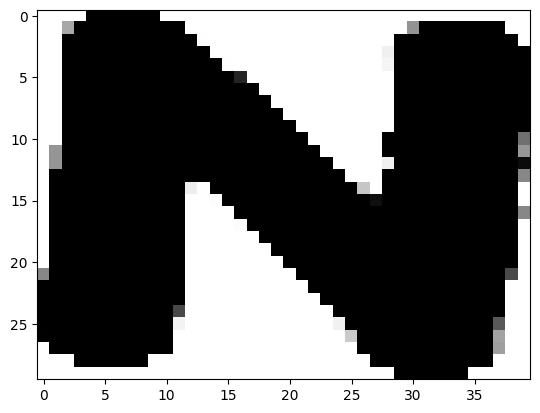

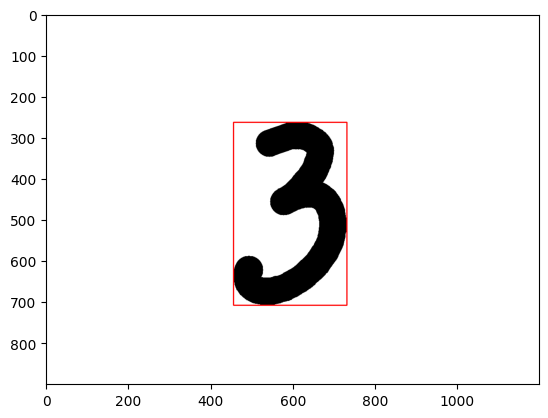

KeyboardInterrupt: 

In [50]:
x_train = []
y_train_char = train_df['label']

count=0

x1 = []
x2 = []
x3 = []
x4 = []

train_images = train_df['image'].to_numpy()

print("Preparing Data: Started")

for dir in train_images:
    count = count+1
    cropped = get_old_boxes(dataset_path, dir, "./temp")
    x1.append(profiles(cropped))
    x2.append(per_Pixel(cropped))
    x3.append(getHistograms(cropped))
    x4.append(intersections(cropped))
    
x_train = np.concatenate((x1, x2, x3, x4), axis=1)

y_train_char = train_df['label']
le = LabelEncoder()
le.fit(y_train_char)
y_train_enc = le.transform(y_train_char)
y_train = np_utils.to_categorical(y_train_enc)
print('Preparing Data: Done')

In [ ]:
x_test = []
y_test_char = test_df['label']

count=0

x1 = []
x2 = []
x3 = []
x4 = []

test_images = test_df['image'].to_numpy()

for dir in test_images:
    count = count+1
    _, cropped = get_bounding_box(dataset_path, dir)
    cropped = cropped[0]
    x1.append(profiles(cropped))
    x2.append(per_Pixel(cropped))
    x3.append(getHistograms(cropped))
    x4.append(intersections(cropped))
    print(count)
    
x_test = np.concatenate((x1, x2, x3, x4), axis=1)

y_test_char = test_df['label']
le = LabelEncoder()
le.fit(y_test_char)
y_test_enc = le.transform(y_test_char)
y_test = np_utils.to_categorical(y_test_enc)

Creating a k-Fold cross validation in order to ensure that our data is being correctly predicted while its being trained without overfitting:

In [ ]:
model_rf = RandomForestClassifier(n_estimators=150, random_state=0)

#Cross Validation Scores
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(model_rf, x_train, y_train,
                              cv=10,
                              scoring='neg_mean_absolute_error',
                              n_jobs=-1)


print("MAE scores:\n", scores)
k = np.arange(10)
plt.plot(k, scores)

Fitting and Running a random forest

In [ ]:
model_rf = RandomForestClassifier(n_estimators=150, random_state=0)
model_rf.fit(x_train, y_train)

y_pred = model_rf.predict(x_test)
values = precision_recall_fscore_support(y_test, y_pred, average = 'macro')
print('Random Forest Precision: ', values[0])
print('Random Forest Recall: ', values[1])
print('Random Forest F-value: ', values[2])
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred))

Random Forest Precision:  0.8610740083937427

Random Forest Recall:  0.47302085015510603

Random Forest F-value:  0.5778132830460543

Random Forest Accuracy:  0.48936170212765956

Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
y_test2 = []
y_pred2 = []

for i in y_test:
  y_test2.append(labels[i.argmax()])

for i in y_pred:
  y_pred2.append(labels[i.argmax()])

ConfusionMatrixDisplay.from_predictions(y_test2, y_pred2)

plt.rcParams['figure.figsize'] = (50, 50)
plt.rcParams.update({'font.size': 15})

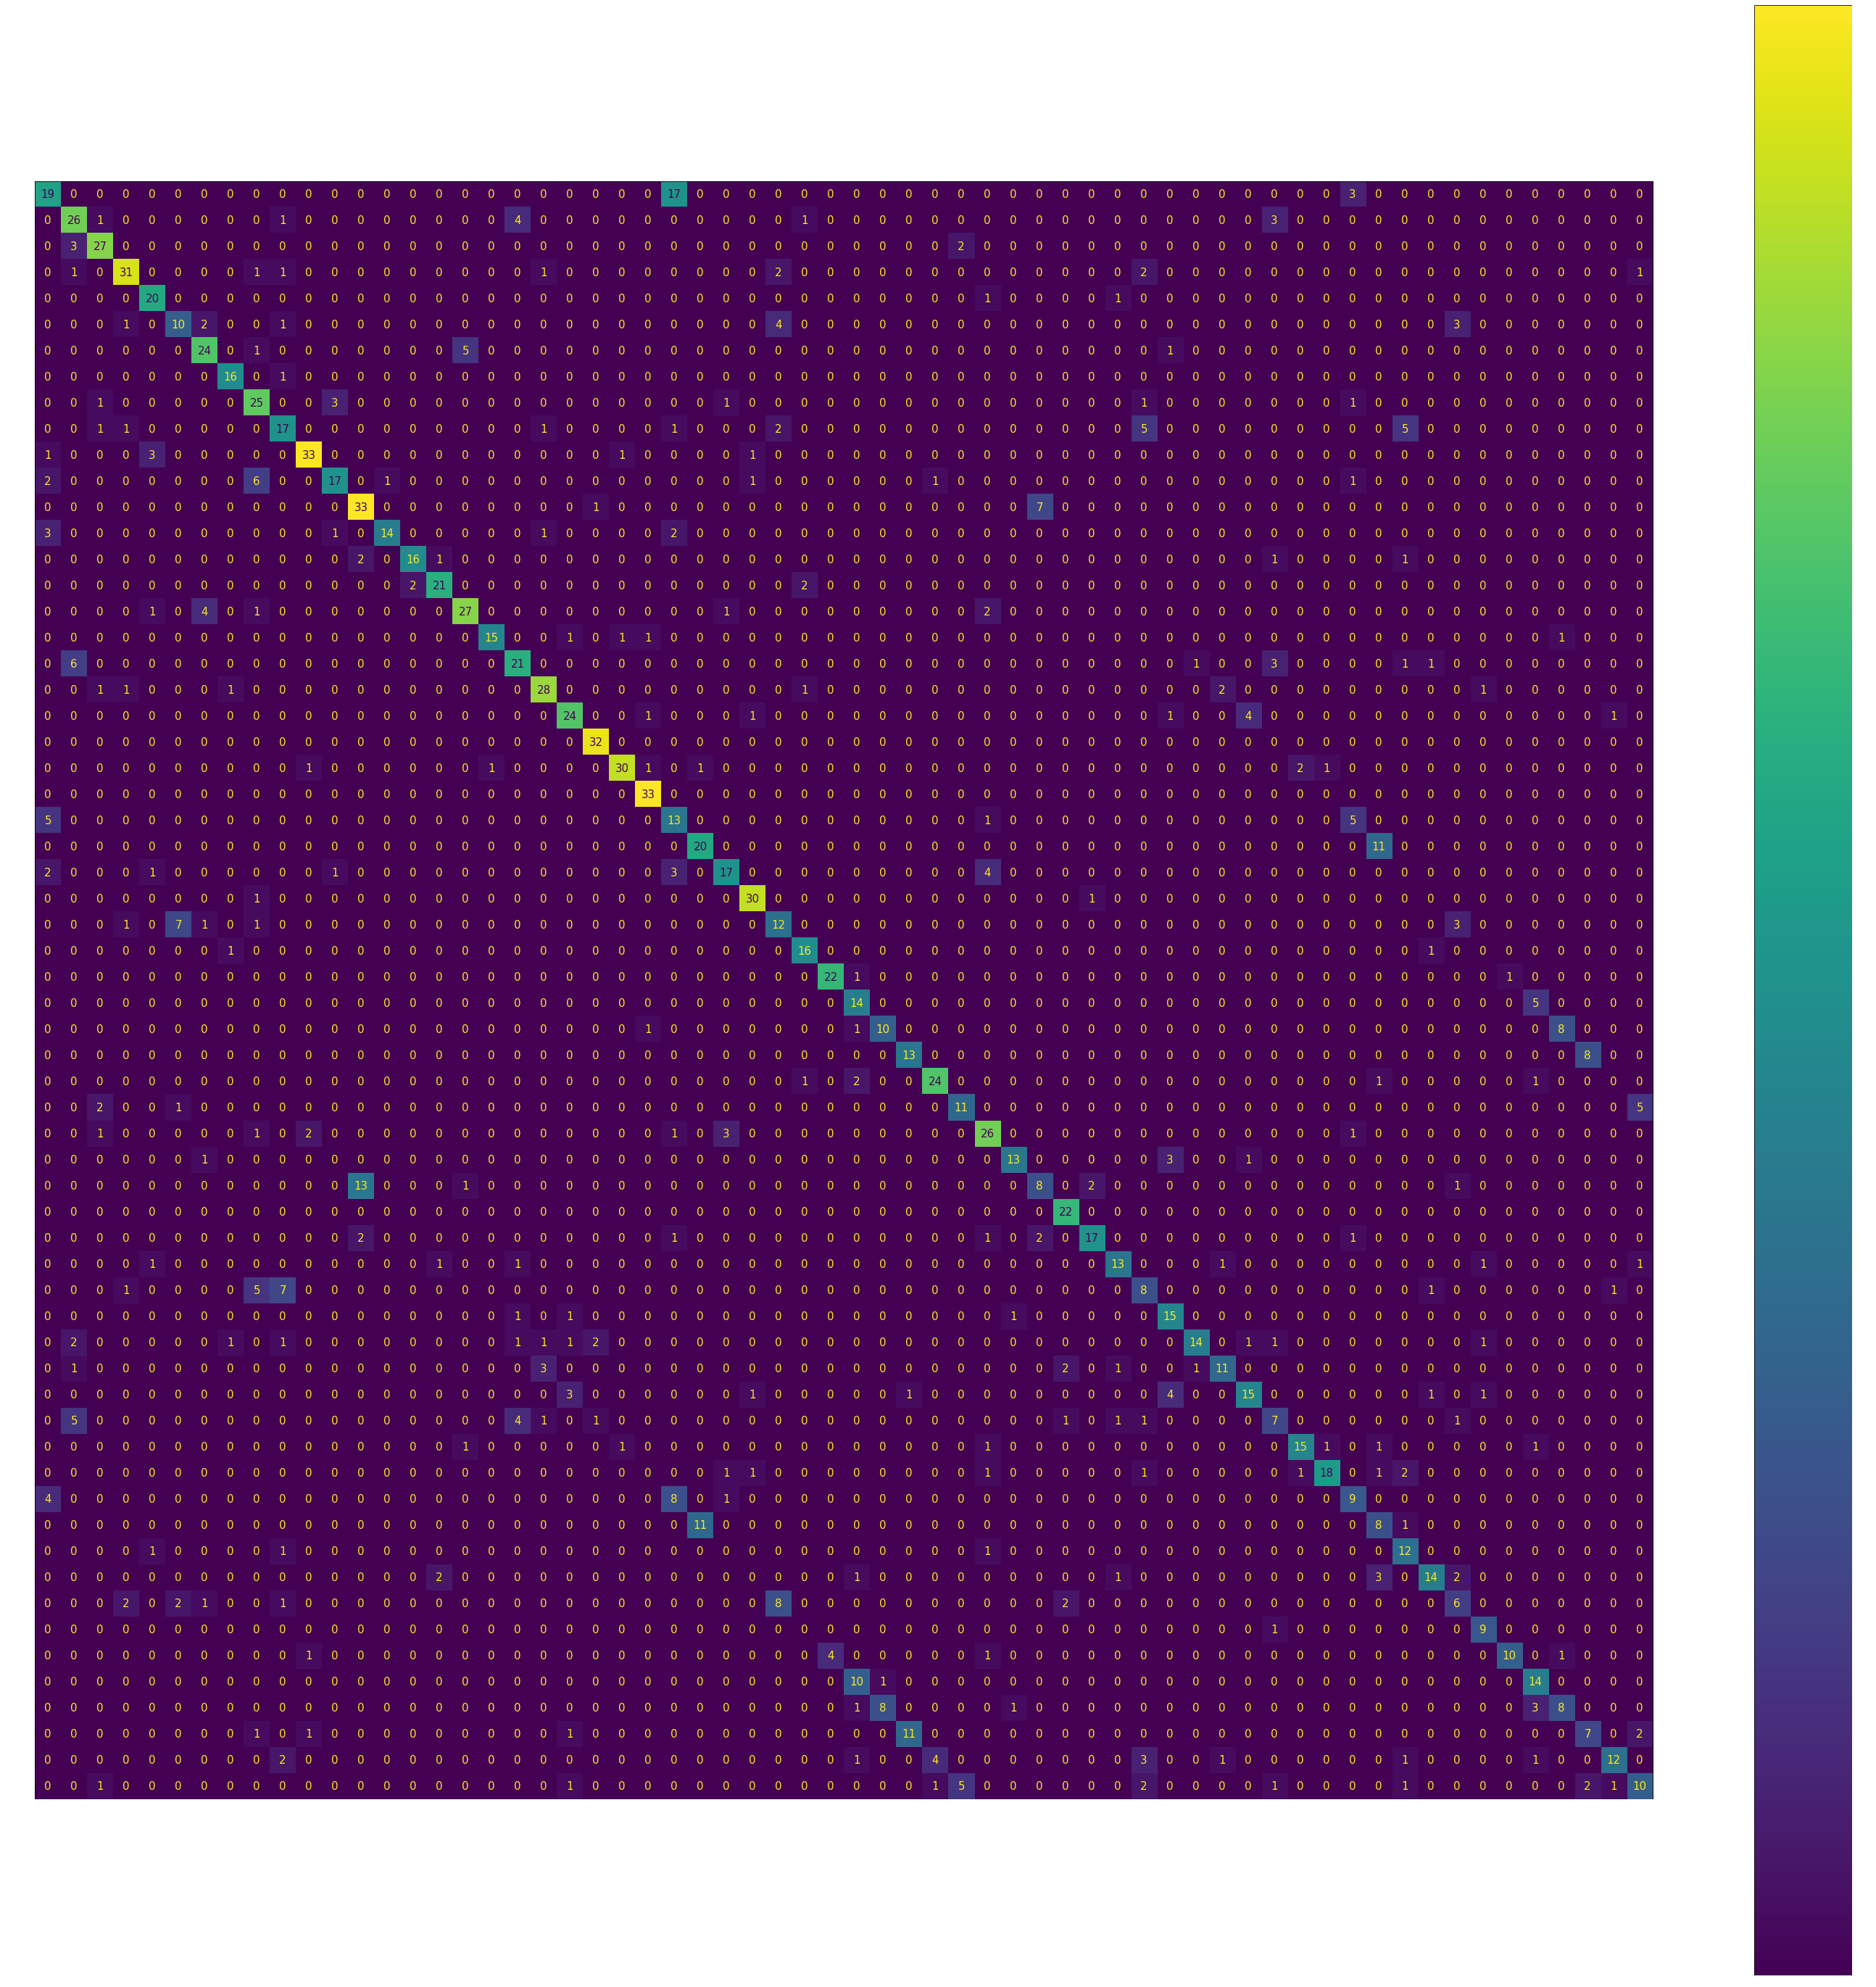

From the previous tests, we can determine that the Random Forest's accuracy has been lowered to around 49% after adding more data to the dataset.

By removing the newly added data, we can retrieve the 77.6% accuracy previously obtained.

*Other models might be better than this one*

## Neural Network (from Scratch) <a id='nn_scratch'></a>

As a first step, we took the initiative to write our functions for the computation of the neural network. We built, in total, 5 modules that follow a similar syntax to the Tensorflow API:

**1. Fully Connected Layer:** This is equivalent to the Dense layer in the Tensorflow/Pytorch API. It consists of neurons that are fully connected to each other.
<img width="200" src="https://www.oreilly.com/api/v2/epubs/9781491980446/files/assets/tfdl_0401.png" />

**2. ReLu Activation Layer:** This is the Rectified Linear Unit non-linearity (activation layer) used at the end of the fully connected layers. It has the following graph:
<img width="400" src="https://iq.opengenus.org/content/images/2021/12/relu.png" />


**3. Softmax Activation Layer:** This is the Softmax layer used at the output of the model. It is used to convert the predictions of the final dense layer into probabilities. It has the following formula:
<img width="200" src="https://lh6.googleusercontent.com/3vcfJ5hJhsMZAMFIbQOEycfVW1t6rh1CXt62DeMk8RPPXVzV4vCcURNm_z_F7618uAeSHT7qT7wE_UiK5Ic0b-Eeuunn6iTGeHWbpAaUAP6-G2ePubeGWCb4_TmSapeaimZqvuUs" />


**4. Cross Entropy Loss:** This is equivalent to the categorical cross entropy loss used in tensorflow. It calculates the loss based on the predicted vs. the expected labels. Below is the formula for the binary cross entropy loss, which is the basis for the categorical cross entropy we need for the purposes of this project.

<img width="400" src="https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/blob/main/images/binary_cross_entropy.jpg?raw=true" />


**5. Sequential Model:** This is the Sequential Model that cascades/stacks different layers togethers.

The detailed implementation of these layers can be found in the *layers* directory under the *src* folder. For the purposes of this notebook, we will simply be loading the model and testing it.

In [31]:
#Import the files from the folders
from layers.full import FullLayer as FullLayer_InHouse
from layers.softmax import SoftMaxLayer as SoftMaxLayer_InHouse
from layers.cross_entropy import CrossEntropyLayer as CrossEntropyLayer_InHouse
from layers.sequential import Sequential as Sequential_InHouse
from layers.relu import ReluLayer as ReluLayer_InHouse

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import tensorflow as tf
import keras

In [32]:
#Load dataset through Tensorflow 
batch_size = 64
full_dataset = keras.utils.image_dataset_from_directory(
    "../input/updated_images",
    seed=123,
    image_size=(28, 28),
    label_mode="categorical",
    batch_size=batch_size,
    color_mode='grayscale')

number_of_batches = full_dataset.cardinality().numpy()

test_size = int(0.1 * number_of_batches)
val_size = int(0.1 * number_of_batches)
train_size = number_of_batches - test_size - val_size

train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"Training Set contains {train_dataset.cardinality().numpy() * batch_size} entries.")
print(f"Validation Set contains {val_dataset.cardinality().numpy() * batch_size} entries.")
print(f"Testing Set contains {test_dataset.cardinality().numpy() * batch_size} entries.")

Found 7998 files belonging to 62 classes.
Training Set contains 6464 entries.
Validation Set contains 768 entries.
Testing Set contains 768 entries.


In [51]:
lr = 10
INPUT_LENGTH = 784

x_train = []
y_train = []
train_dataset_unbatched = train_dataset.unbatch()
#It is a list of tuples, where in each tuple you have a batch of input, then a batch of labels
for image, label in train_dataset_unbatched:
    x_train.append(image)
    y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)

#Flatten the image into a vector
x_train = [element.flatten() for element in x_train]
x_train = np.array(x_train)
print(x_train.shape)
print(y_train.shape)


(6464, 784)
(6464, 62)


In [53]:
epochs = 15

model = Sequential_InHouse((FullLayer_InHouse(INPUT_LENGTH, 200), 
                            ReluLayer_InHouse(), 
                            FullLayer_InHouse(200, 62), 
                            SoftMaxLayer_InHouse()),
                            CrossEntropyLayer_InHouse())


_ = model.fit(x_train, y_train, epochs=epochs, lr=lr)

[[-0.0287332  -0.08070341  0.03580088 ... -0.01842239 -0.05473314
  -0.04430633]
 [ 0.07629619  0.02487563 -0.02338566 ... -0.10033775 -0.03896658
   0.04631738]
 [ 0.03679433 -0.05738644  0.08580112 ... -0.04258517 -0.06378026
  -0.02849398]
 ...
 [ 0.05037449  0.02220638  0.00657093 ... -0.08664902  0.03106024
  -0.01369062]
 [ 0.02842555  0.02682362 -0.00280463 ... -0.0655111   0.04611416
  -0.02146906]
 [ 0.0692083   0.02131583  0.0090174  ...  0.04325005 -0.04256375
  -0.0006855 ]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-3.06708680e-02 -1.24602250e-02  1.51692158e-01 ... -2.18080773e-01
  -1.89394656e-02 -7.29348861e-02]
 [ 4.28064946e+01  5.55788876e-02  1.58075412e+01 ...  9.07471936e+00
   4.91624744e+01 -2.32341387e-02]
 [ 4.09491046e+01 -8.80123662e-02  1.87677783e+00 ...  2.15812541e-01
   1.57208545e+01  1.19921871e-01]
 ...
 [ 1.21389942e+02 -1.45867709e-01  7.3750846

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-3.06708680e-02 -1.24602250e-02  1.51692158e-01 ... -2.18080773e-01
  -1.89394656e-02 -7.29348861e-02]
 [ 4.28064946e+01  5.55788876e-02  1.58075412e+01 ...  9.07471936e+00
   4.91624744e+01 -2.32341387e-02]
 [ 4.09491046e+01 -8.80123662e-02  1.87677783e+00 ...  2.15812541e-01
   1.57208545e+01  1.19921871e-01]
 ...
 [ 1.21389942e+02 -1.45867709e-01  7.3750846

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-3.06708680e-02 -1.24602250e-02  1.51692158e-01 ... -2.18080773e-01
  -1.89394656e-02 -7.29348861e-02]
 [ 4.28064946e+01  5.55788876e-02  1.58075412e+01 ...  9.07471936e+00
   4.91624744e+01 -2.32341387e-02]
 [ 4.09491046e+01 -8.80123662e-02  1.87677783e+00 ...  2.15812541e-01
   1.57208545e+01  1.19921871e-01]
 ...
 [ 1.21389942e+02 -1.45867709e-01  7.3750846

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-3.06708680e-02 -1.24602250e-02  1.51692158e-01 ... -2.18080773e-01
  -1.89394656e-02 -7.29348861e-02]
 [ 4.28064946e+01  5.55788876e-02  1.58075412e+01 ...  9.07471936e+00
   4.91624744e+01 -2.32341387e-02]
 [ 4.09491046e+01 -8.80123662e-02  1.87677783e+00 ...  2.15812541e-01
   1.57208545e+01  1.19921871e-01]
 ...
 [ 1.21389942e+02 -1.45867709e-01  7.37508464e+01 ... -3.81016172e-02
   3.62709081e+01  4.79542195e-02]
 [ 6.47345092e-02 -2.03544505e-02  1.12529807e-02 ...  7.06026641e-02
   5.10675648e-02 -3.51388885e-02]
 [-1.73201592e-02 -1.95781283e-02 -2.34824599e-02 ...  1.05100316e-01
   9.67998881e-02 -3.62062304e-02]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-3.06708680e-02 -1.24602250e-02  1.51692158e-01 ... -2.18080773e-01
  -1.89394656e-02 -7.29348861e-02]
 [ 4.28064946e+01  5.55788876e-02  1.58075412e+01 ...  9.07471936e+00
   4.91624744e+01 -2.32341387e-02]
 [ 4.09491046e+01 -8.80123662e-02  1.87677783e+00 ...  2.15812541e-01
   1.57208545e+01  1.19921871e-01]
 ...
 [ 1.21389942e+02 -1.45867709e-01  7.3750846

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.57092966e-03 ... -8.66490170e-02
   3.10602442e-02 -1.36906217e-02]
 [-3.06957276e+01 -2.42074770e+01 -2.92725180e+01 ... -3.86941810e+01
  -4.20878801e+01 -4.13455326e+01]
 [-1.04990865e+01 -1.25131260e+01 -1.69011323e+01 ... -7.44354954e+00
  -6.72803788e+00 -7.11520434e+00]]
[[-7.95022218e+01 -8.11693690e+01 -7.42352886e+01 ... -6.83162143e+01
  -7.94671215e+01 -8.40904691e+01]
 [ 7.62961857e-02  2.48756277e-02 -2.33856636e-02 ... -1.00337746e-01
  -3.89665832e-02  4.63173776e-02]
 [-3.92666114e+01 -3.67451381e+01 -2.99809395e+01 ... -3.55149409e+01
  -3.98880879e+01 -4.49286628e+01]
 ...
 [ 5.03744927e-02  2.22063799e-02  6.5709296

However, we were unable to plot the accuracies and losses of this neural network.

## Neural Network (using Tensorflow) <a id='nn_tensorflow'></a>

### Feature Extraction

The first step is to import the data and extract features from it to feed it to the Neural Network. We began by splitting the data between training and testing data with a ratio of 80-20%. 

The training data will be further split into training and validation when performing K-fold cross-validation at a later stage.

In [54]:
df = pd.read_csv('../input/english.csv')

# 80% of the data is selected for training
train_df = df.sample(frac=0.80, random_state=123)
 
# drop the training data from the original dataframe
test_df = df.drop(train_df.index)

We used feature extraction functions to get information about the height and width of the letter at multiple locations, the number of intersections with virtual vertical and horizontal lines, the pixel vertical and horizontal pixel densities, as well as the smoothness of the character from all 4 directions. All the features are normalized between 0 and 1.

In [55]:
from src.features import profilesNorm
from src.features import per_PixelNorm
from src.features import intersectionsNorm
from src.features import getHistogramsNorm

ImportError: cannot import name 'profilesNorm' from 'src.features' (C:\Users\Anton\Desktop\Project 2\backend\notebooks\..\src\features.py)

In [ ]:
x_train = []

x1 = []
x2 = []
x3 = []
x4 = []

train_images = train_df['image'].to_numpy()
for dir in train_images:
    cropped = get_bounding_box("Dataset", dir, "results") #make sure bounding box is correct
    x1.append(profilesNorm(cropped))
    x2.append(per_PixelNorm(cropped))
    x3.append(getHistogramsNorm(cropped))
    x4.append(intersectionsNorm(cropped))
    
x_train = np.concatenate((x1, x2, x3, x4), axis=1)


x_test = []

x1 = []
x2 = []
x3 = []
x4 = []

test_images = test_df['image'].to_numpy()
for dir in test_images:
    cropped = get_bounding_box("Dataset", dir, "results")
    x1.append(profilesNorm(cropped))
    x2.append(per_PixelNorm(cropped))
    x3.append(getHistogramsNorm(cropped))
    x4.append(intersectionsNorm(cropped))
    
x_test = np.concatenate((x1, x2, x3, x4), axis=1)

The next step was to encode the labels of the training and validation datasets. This is needed because the labels are alphabetic (strings), while the output of the Neural Network is numeric. 

We chose one-hot encoding to represent our 62 classes. As such, each label is represented by 62 bits, all of which are 0 except for 1 which indicates the label. 

To do so, we used the LabelEncode object from Sci-kit Learn.

In [ ]:
from sklearn.preprocessing import LabelEncoder

y_train_char = train_df['label']
le = LabelEncoder()
le.fit(y_train_char)
y_train_enc = le.transform(y_train_char)
y_train = np_utils.to_categorical(y_train_enc)

y_test = test_df['label']
y_test_enc = le.transform(y_test_char)
y_test = np_utils.to_categorical(y_test_enc)

### Building the Neural Network

Tensorflow offers objects and functions to build Neural Networks, with access to all design parameters, such as the types of layers, number of layers, number of neurons per layer, and activation functions.

Our Neural Netwrok model is as follows:

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

def createModel():
    model = Sequential()
    model.add(Dense(units=64, input_dim=264, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=62, activation='softmax'))
    
    return model

The features extracted from each image constitute a vector of 264 elements. Tha is why the input layer of our Neural Network has 'input_dim=264'. 

The Dense layer in Keras is the regular deeply connected layer. It takes as input the number of neurons in the layer, as well as the activation function of the neurons. We went with the 'reLU' activation function shown below:
![Image](https://www.nomidl.com/wp-content/uploads/2022/04/image-10.png)

The Dropout layer randomly sets input units to 0 with the frequency passed as input to Dropout(). This strategy helps in reducing overfitting. Dropout can be better visualized as follows: 
![Image](https://carpentries-incubator.github.io/deep-learning-intro/fig/neural_network_sketch_dropout.png)

The output layer of the Neural Network has 62 outputs, equal to the number of classes. The activation function of the output layer is 'softmax'. This function will train the network to output probability values (between 0 and 1) over all the available classes. As such, it is used for multi-class classification.

In [ ]:
model = createModel()

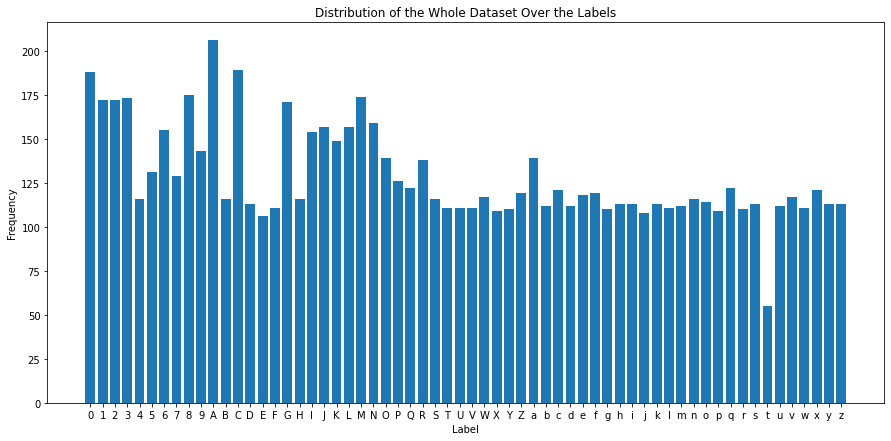

In [ ]:
df = pd.read_csv('./Dataset/english.csv')
labelfreq = df["label"].value_counts().sort_index()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
plt.bar(labelfreq.index, labelfreq)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of the Whole Dataset Over the Labels')
plt.show()

In [ ]:
model.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, 64)                16960     
                                                                 
 dropout_270 (Dropout)       (None, 64)                0         
                                                                 
 dense_361 (Dense)           (None, 128)               8320      
                                                                 
 dropout_271 (Dropout)       (None, 128)               0         
                                                                 
 dense_362 (Dense)           (None, 128)               16512     
                                                                 
 dropout_272 (Dropout)       (None, 128)               0         
                                                                 
 dense_363 (Dense)           (None, 62)              

Then, to compile our model, we use the 'categorical_crossentropy' loss function and the Adam optimization algorithm.

The 'categorical_crossentropy' function is the most common function for multi-class classification. It gives a measure of how well the network is learning the data. The smaller the loss, the better the network has learned the data.

**Optimization Background**
Optimizers define how the neural network learns. They allow to find the values of parameters (weights) such that the loss function is minimized. 

The original optimizer was Gradient Descent. It consisted of taking small steps iteratively in the direction that miminimizes loss. These steps would be taken every epoch,
meaning after going over the whole dataset. As a result, the optimizer might 
hover over the optimal value back and forth without reaching it. 

To remedy the shortcomings of Gradient Descent, Stochastic Gradient Descent (SGD), which updates the weights after each datapoint intead of the whole dataset, was introduced. However, it may result in noisy jumps that deviate from the optimal value, since the process is influenced by every sample.

Mini-Batch Gradient Descent was introduced as a compromise, updating the weights after N samples.

Another way of improving SGD was the use of Momentum. When training examples follow a similar pattern, the network can learn faster by paying little attention to the few samples that disturb it. But this could lead the model to evolve too fast and to ignore non-typical samples.

A possible solution is adding an Accelerator term to the SGD + Momentum optimizer. As the model gains momentum and encounters an odd sample, the accelerator term decelerates the learning rate. 

All the optimizers discussed above work for 2D and fixed loss functions. Adadelta allows adaptive and 3D loss functions to be minimized. Adam is built on top of Adadelta by incorporating Momentum into the optimization. It offers fast convergence and is the most used optimizers in many applications.


In [ ]:
def compileModel(model):
    model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

Now our model is ready for training. However, an important parameter for training is the number of epochs, or in other terms, the number of times the model iterates over the whole dataset while training. It is necessary to tune this paramater, because, if it were too low, the model would not fit the data, whereas if it were too high, the model might overfit and become very specific to the training data. 

To determine the ideal number of epochs for training, we developed a function that trains the model for different values of epochs and plots performance measures such as accuracy, loss, precision, and recall as a function of the number of epochs.

In [ ]:
def tuneEpochs(epochs, x_train, y_train, x_test, y_test):
    loss = []
    accuracy = []
    precision = []
    recall = []
    for e in epochs:
        model = createModel()
        compileModel(model)
        model.fit(x_train, y_train, epochs=e, batch_size=128, verbose=0)
        results = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
        loss.append(results[0])
        accuracy.append(results[1])
        precision.append(results[2])
        recall.append(results[3])
        
    return [loss, accuracy, precision, recall]

We will use this function to compare the performance measure for epochs in the range of 55 to 115 with steps of 10.

Epoch 1/55
50/50 [==============================] - 2s 6ms/step - loss: 3.9994 - accuracy: 0.0563 - precision_15: 1.0000 - recall_15: 3.1299e-04
Epoch 2/55
50/50 [==============================] - 0s 6ms/step - loss: 3.2200 - accuracy: 0.1689 - precision_15: 0.7591 - recall_15: 0.0163
Epoch 3/55
50/50 [==============================] - 0s 5ms/step - loss: 2.4769 - accuracy: 0.2840 - precision_15: 0.6057 - recall_15: 0.0534
Epoch 4/55
50/50 [==============================] - 0s 6ms/step - loss: 2.0867 - accuracy: 0.3604 - precision_15: 0.6080 - recall_15: 0.1163
Epoch 5/55
50/50 [==============================] - 0s 6ms/step - loss: 1.8562 - accuracy: 0.4250 - precision_15: 0.6399 - recall_15: 0.1743
Epoch 6/55
50/50 [==============================] - 0s 6ms/step - loss: 1.7112 - accuracy: 0.4582 - precision_15: 0.6438 - recall_15: 0.2207
Epoch 7/55
50/50 [==============================] - 0s 7ms/step - loss: 1.5828 - accuracy: 0.4934 - precision_15: 0.6815 - recall_15: 0.2729
Epoch 8/5

50/50 [==============================] - 0s 7ms/step - loss: 0.7305 - accuracy: 0.7341 - precision_16: 0.8075 - recall_16: 0.6480
Epoch 60/65
50/50 [==============================] - 1s 18ms/step - loss: 0.7251 - accuracy: 0.7336 - precision_16: 0.8079 - recall_16: 0.6423
Epoch 61/65
50/50 [==============================] - 0s 8ms/step - loss: 0.7268 - accuracy: 0.7302 - precision_16: 0.8070 - recall_16: 0.6466
Epoch 62/65
50/50 [==============================] - 0s 7ms/step - loss: 0.7230 - accuracy: 0.7358 - precision_16: 0.8091 - recall_16: 0.6552
Epoch 63/65
50/50 [==============================] - 0s 8ms/step - loss: 0.7290 - accuracy: 0.7338 - precision_16: 0.8092 - recall_16: 0.6505
Epoch 64/65
50/50 [==============================] - 0s 10ms/step - loss: 0.7107 - accuracy: 0.7358 - precision_16: 0.8132 - recall_16: 0.6548
Epoch 65/65
13/13 [==============================] - 1s 4ms/step - loss: 0.7894 - accuracy: 0.7322 - precision_16: 0.8052 - recall_16: 0.6752
Epoch 1/75
50/50

50/50 [==============================] - 1s 10ms/step - loss: 0.9550 - accuracy: 0.6624 - precision_18: 0.7783 - recall_18: 0.5440
Epoch 32/85
50/50 [==============================] - 1s 12ms/step - loss: 0.9309 - accuracy: 0.6698 - precision_18: 0.7746 - recall_18: 0.5480
Epoch 33/85
50/50 [==============================] - 0s 9ms/step - loss: 0.9274 - accuracy: 0.6656 - precision_18: 0.7756 - recall_18: 0.5556
Epoch 34/85
50/50 [==============================] - 1s 12ms/step - loss: 0.9012 - accuracy: 0.6739 - precision_18: 0.7802 - recall_18: 0.5588
Epoch 35/85
50/50 [==============================] - 1s 10ms/step - loss: 0.9065 - accuracy: 0.6740 - precision_18: 0.7799 - recall_18: 0.5624
Epoch 36/85
50/50 [==============================] - 1s 14ms/step - loss: 0.8835 - accuracy: 0.6892 - precision_18: 0.7822 - recall_18: 0.5728
Epoch 37/85
50/50 [==============================] - 1s 11ms/step - loss: 0.8885 - accuracy: 0.6861 - precision_18: 0.7904 - recall_18: 0.5693
Epoch 38/85


50/50 [==============================] - 0s 6ms/step - loss: 0.7151 - accuracy: 0.7299 - precision_19: 0.8117 - recall_19: 0.6469
Epoch 60/95
50/50 [==============================] - 0s 6ms/step - loss: 0.7545 - accuracy: 0.7222 - precision_19: 0.8071 - recall_19: 0.6365
Epoch 61/95
50/50 [==============================] - 0s 6ms/step - loss: 0.7248 - accuracy: 0.7346 - precision_19: 0.8123 - recall_19: 0.6568
Epoch 62/95
50/50 [==============================] - 0s 6ms/step - loss: 0.7278 - accuracy: 0.7363 - precision_19: 0.8058 - recall_19: 0.6499
Epoch 63/95
50/50 [==============================] - 0s 6ms/step - loss: 0.7156 - accuracy: 0.7340 - precision_19: 0.8128 - recall_19: 0.6538
Epoch 64/95
50/50 [==============================] - 0s 5ms/step - loss: 0.7252 - accuracy: 0.7363 - precision_19: 0.8154 - recall_19: 0.6562
Epoch 65/95
50/50 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.7371 - precision_19: 0.8129 - recall_19: 0.6576
Epoch 66/95
50/50 

50/50 [==============================] - 0s 6ms/step - loss: 0.6483 - accuracy: 0.7545 - precision_20: 0.8251 - recall_20: 0.6831
Epoch 78/105
50/50 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.7593 - precision_20: 0.8178 - recall_20: 0.6776
Epoch 79/105
50/50 [==============================] - 0s 6ms/step - loss: 0.6764 - accuracy: 0.7487 - precision_20: 0.8125 - recall_20: 0.6781
Epoch 80/105
50/50 [==============================] - 0s 6ms/step - loss: 0.6575 - accuracy: 0.7493 - precision_20: 0.8174 - recall_20: 0.6789
Epoch 81/105
50/50 [==============================] - 0s 6ms/step - loss: 0.6387 - accuracy: 0.7612 - precision_20: 0.8242 - recall_20: 0.6895
Epoch 82/105
50/50 [==============================] - 0s 6ms/step - loss: 0.6636 - accuracy: 0.7548 - precision_20: 0.8239 - recall_20: 0.6881
Epoch 83/105
50/50 [==============================] - 0s 6ms/step - loss: 0.6525 - accuracy: 0.7568 - precision_20: 0.8222 - recall_20: 0.6867
Epoch 84/105

50/50 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.7487 - precision_21: 0.8137 - recall_21: 0.6803
Epoch 86/115
50/50 [==============================] - 0s 6ms/step - loss: 0.6602 - accuracy: 0.7537 - precision_21: 0.8223 - recall_21: 0.6881
Epoch 87/115
50/50 [==============================] - 0s 7ms/step - loss: 0.6502 - accuracy: 0.7565 - precision_21: 0.8261 - recall_21: 0.6883
Epoch 88/115
50/50 [==============================] - 0s 6ms/step - loss: 0.6555 - accuracy: 0.7552 - precision_21: 0.8209 - recall_21: 0.6851
Epoch 89/115
50/50 [==============================] - 0s 5ms/step - loss: 0.6294 - accuracy: 0.7667 - precision_21: 0.8322 - recall_21: 0.7003
Epoch 90/115
50/50 [==============================] - 0s 5ms/step - loss: 0.6472 - accuracy: 0.7543 - precision_21: 0.8186 - recall_21: 0.6947
Epoch 91/115
50/50 [==============================] - 0s 5ms/step - loss: 0.6236 - accuracy: 0.7645 - precision_21: 0.8265 - recall_21: 0.6978
Epoch 92/115

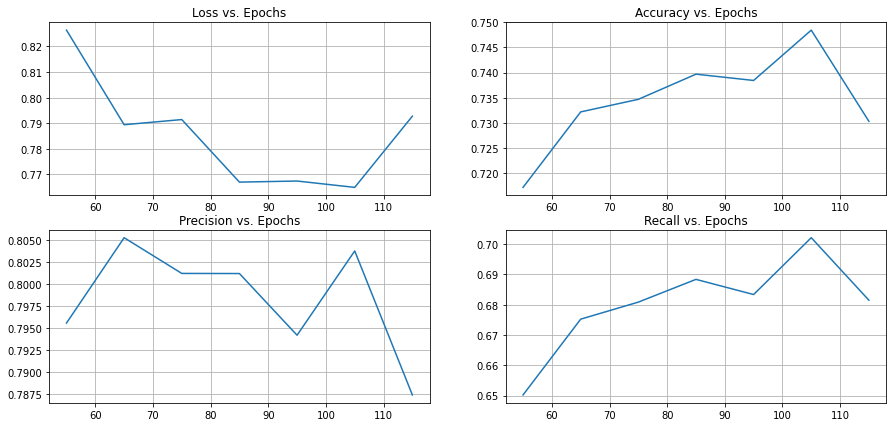

In [ ]:
epochs = [55,65,75,85,95,105,115]
[loss, accuracy, precision, recall] = tuneEpochs(epochs , x_train, y_train, x_test, y_test)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
plt.subplot(2,2,1)
plt.plot(epochs, loss)
plt.title('Loss vs. Epochs')
plt.grid()

plt.subplot(2,2,2)
plt.plot(epochs, accuracy)
plt.title('Accuracy vs. Epochs')
plt.grid()

plt.subplot(2,2,3)
plt.plot(epochs, precision)
plt.title('Precision vs. Epochs')
plt.grid()

plt.subplot(2,2,4)
plt.plot(epochs, recall)
plt.title('Recall vs. Epochs')
plt.grid()

The best performance is clearly at epochs = 105. After tuning the number of epochs needed, we will use this number to perform K-fold cross validation.

The training dataset will be divided into 5 equal splits. Then 5 models will be trained. Each model will use 4 of the 5 splits for training, and the remaining one for validation. The best model will be chosen based on validation accuracy. Finally, the model will be evaluated on the testing data (the one of the original 80-20% split)

Epoch 1/105
160/160 [==============================] - 2s 4ms/step - loss: 3.6721 - accuracy: 0.0933 - precision_59: 0.6739 - recall_59: 0.0061 
Epoch 2/105
160/160 [==============================] - 1s 3ms/step - loss: 2.5107 - accuracy: 0.2692 - precision_59: 0.5942 - recall_59: 0.0561
Epoch 3/105
160/160 [==============================] - 1s 3ms/step - loss: 2.0141 - accuracy: 0.3818 - precision_59: 0.5992 - recall_59: 0.1389
Epoch 4/105
160/160 [==============================] - 1s 3ms/step - loss: 1.7667 - accuracy: 0.4300 - precision_59: 0.6331 - recall_59: 0.2052
Epoch 5/105
160/160 [==============================] - 1s 4ms/step - loss: 1.6097 - accuracy: 0.4867 - precision_59: 0.6708 - recall_59: 0.2623
Epoch 6/105
160/160 [==============================] - 1s 4ms/step - loss: 1.5070 - accuracy: 0.5006 - precision_59: 0.6921 - recall_59: 0.3118
Epoch 7/105
160/160 [==============================] - 1s 4ms/step - loss: 1.4002 - accuracy: 0.5301 - precision_59: 0.6929 - recall_59

160/160 [==============================] - 1s 4ms/step - loss: 1.4000 - accuracy: 0.5335 - precision_60: 0.7024 - recall_60: 0.3476
Epoch 8/105
160/160 [==============================] - 1s 4ms/step - loss: 1.3350 - accuracy: 0.5552 - precision_60: 0.7054 - recall_60: 0.3658
Epoch 9/105
160/160 [==============================] - 1s 3ms/step - loss: 1.2799 - accuracy: 0.5671 - precision_60: 0.7145 - recall_60: 0.3883
Epoch 10/105
160/160 [==============================] - 1s 3ms/step - loss: 1.2227 - accuracy: 0.5861 - precision_60: 0.7295 - recall_60: 0.4263
Epoch 11/105
160/160 [==============================] - 1s 4ms/step - loss: 1.1739 - accuracy: 0.6013 - precision_60: 0.7419 - recall_60: 0.4448
Epoch 12/105
160/160 [==============================] - 1s 4ms/step - loss: 1.1428 - accuracy: 0.6045 - precision_60: 0.7378 - recall_60: 0.4513
Epoch 13/105
160/160 [==============================] - 1s 4ms/step - loss: 1.1158 - accuracy: 0.6172 - precision_60: 0.7467 - recall_60: 0.4712


160/160 [==============================] - 1s 4ms/step - loss: 1.0755 - accuracy: 0.6268 - precision_61: 0.7507 - recall_61: 0.4918
Epoch 14/105
160/160 [==============================] - 1s 4ms/step - loss: 1.0893 - accuracy: 0.6228 - precision_61: 0.7532 - recall_61: 0.4885
Epoch 15/105
160/160 [==============================] - 1s 3ms/step - loss: 1.0329 - accuracy: 0.6356 - precision_61: 0.7581 - recall_61: 0.5057
Epoch 16/105
160/160 [==============================] - 1s 3ms/step - loss: 1.0278 - accuracy: 0.6389 - precision_61: 0.7543 - recall_61: 0.5086
Epoch 17/105
160/160 [==============================] - 1s 3ms/step - loss: 0.9932 - accuracy: 0.6567 - precision_61: 0.7660 - recall_61: 0.5303
Epoch 18/105
160/160 [==============================] - 1s 3ms/step - loss: 0.9888 - accuracy: 0.6508 - precision_61: 0.7599 - recall_61: 0.5268
Epoch 19/105
160/160 [==============================] - 1s 4ms/step - loss: 0.9414 - accuracy: 0.6631 - precision_61: 0.7739 - recall_61: 0.553

160/160 [==============================] - 1s 4ms/step - loss: 0.9577 - accuracy: 0.6651 - precision_62: 0.7725 - recall_62: 0.5421
Epoch 20/105
160/160 [==============================] - 1s 4ms/step - loss: 0.9358 - accuracy: 0.6774 - precision_62: 0.7762 - recall_62: 0.5550
Epoch 21/105
160/160 [==============================] - 1s 4ms/step - loss: 0.9233 - accuracy: 0.6723 - precision_62: 0.7773 - recall_62: 0.5632
Epoch 22/105
160/160 [==============================] - 1s 4ms/step - loss: 0.9101 - accuracy: 0.6764 - precision_62: 0.7801 - recall_62: 0.5657
Epoch 23/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8957 - accuracy: 0.6747 - precision_62: 0.7807 - recall_62: 0.5712
Epoch 24/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8844 - accuracy: 0.6813 - precision_62: 0.7729 - recall_62: 0.5712
Epoch 25/105
160/160 [==============================] - 1s 4ms/step - loss: 0.8666 - accuracy: 0.6819 - precision_62: 0.7801 - recall_62: 0.583

160/160 [==============================] - 1s 3ms/step - loss: 0.8639 - accuracy: 0.6919 - precision_63: 0.7836 - recall_63: 0.5914
Epoch 26/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8542 - accuracy: 0.6984 - precision_63: 0.7895 - recall_63: 0.5966
Epoch 27/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8415 - accuracy: 0.7011 - precision_63: 0.7742 - recall_63: 0.6009
Epoch 28/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8433 - accuracy: 0.7029 - precision_63: 0.7894 - recall_63: 0.6043
Epoch 29/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8340 - accuracy: 0.6993 - precision_63: 0.7926 - recall_63: 0.6064
Epoch 30/105
160/160 [==============================] - 1s 3ms/step - loss: 0.8213 - accuracy: 0.7036 - precision_63: 0.7931 - recall_63: 0.6090
Epoch 31/105
160/160 [==============================] - 1s 3ms/step - loss: 0.7990 - accuracy: 0.7138 - precision_63: 0.8025 - recall_63: 0.627

INFO:tensorflow:Assets written to: nn_model\assets


INFO:tensorflow:Assets written to: nn_model\assets


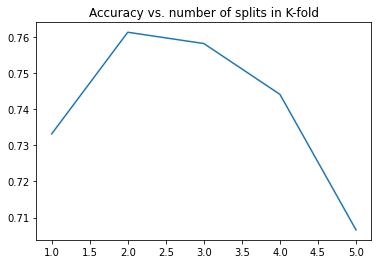

In [ ]:
from sklearn.model_selection import KFold

models = []
accuracies = []

n_split = 5

for train_index,test_index in KFold(n_split).split(x_train):
    x,x_val=x_train[train_index],x_train[test_index]
    y,y_val=y_train[train_index],y_train[test_index]
    
    model=createModel()
    compileModel(model)
    model.fit(x, y, epochs=105)
    
    models.append(model)
    
    res = model.evaluate(x_val, y_val)
    accuracies.append(res[1])
    
k = [1,2,3,4,5]
plt.plot(k, accuracies)
plt.title('Accuracy vs. number of splits in K-fold')
plt.grid()

best = models[np.argmax(accuracies)]
best.save('nn_model')

Testing the best model usinf the test data

In [ ]:
results1 = best.evaluate(x_test, y_test)

50/50 [==============================] - 0s 2ms/step - loss: 0.8771 - accuracy: 0.7347 - precision_60: 0.7860 - recall_60: 0.6871


## Convolutional Neural Network (using Tensorflow) <a id=cnn></a>

### CNN Crash Course

A convolutional network builds on the idea of a neural network and introduces a new type of layer: the convolutional layer.

<img src="https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/blob/main/images/cnn.webp?raw=true" width=500 /> 

This layer introduces a filter, made out of cells, where each cell has a weight. The filter is *passed over* the data, multiplying, at each point, the values of the data with the weights of the kernel. Afterwards, the products are then summed to produce a single value for every cell the kernel passes over.

<img src="https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/raw/main/images/filters.png" width=500/>

Kernels vary in size, but are usually square in shape (e.g., 2x2, 3x3). During training, the weights of the filter are updated as to produce the desired output on the training images. 

There are two main parameters that one must take into account when using convoltutional layers:

**1. Stride:** This parameter defines by how much the kernel is shifting on every iteration of the convolution

**2. Padding:** This parameter defines how the kernel will interact with cells on the boundary. In tensorflow, there are two main options:

&nbsp;&nbsp;&nbsp;&nbsp; **a. Same:** A padding of *same* appends 0 to the boundaries, in order to result in an output image of same size as the input (hence the name!)

&nbsp;&nbsp;&nbsp;&nbsp; **b. Valid:** A padding of *valid* does not add any padding to the input. In this case, some cells might be disregarded if the kernel (along with the chosen stride) does not exactly match the shape of the input.
 
Below is an image that portrays this process:
![image](https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/raw/main/images/padding.png)

A CNN usually consists of several convolutional layers, where each layers consists of several kernels. After training, the kernels would represents a certain feature that help in predicting the output (because of this, a kernel is also referred to as *feature map*, because it *maps* the input image into a certain feature). For instance, some kernels might learn to detect edges; others might learn to detect horizontal surfaces, vertical surfaces, diagonal splits...

An example of an image of a cat being processed by a CNN is shown below:
![cat_original](https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/raw/main/images/cat_original.png)
![cat_cnn](https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/raw/main/images/cat_conv.png)

We can see how each kernel/feature map highlights something: for instance, some highlight the foreground, while others highlight edges.

Furthermore, the deeper the network is, the more complex the features discovered are. 

### Building a Model

Tensorflow presents a simple way to build complex CNN models. As such, we will be using it do build our CNN model.

First step is to import the data. Recall that the input images are stored inside folders, where each folder corresponds to a class. As such, we can use the *image_dataset_from_directory* function provided by TF2.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
import pandas as pd
import tensorflow as tf
import keras

In [ ]:
batch_size = 64
full_dataset = keras.utils.image_dataset_from_directory(
    "../input/updated_images",
    seed=123,
    image_size=(28, 28),
    label_mode="categorical",
    batch_size=batch_size,
    color_mode='grayscale')

number_of_batches = full_dataset.cardinality().numpy()

test_size = int(0.1 * number_of_batches)
val_size = int(0.1 * number_of_batches)
train_size = number_of_batches - test_size - val_size

train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"Training Set contains {train_dataset.cardinality().numpy() * batch_size} entries.")
print(f"Validation Set contains {val_dataset.cardinality().numpy() * batch_size} entries.")
print(f"Testing Set contains {test_dataset.cardinality().numpy() * batch_size} entries.")

Found 7998 files belonging to 62 classes.
Training Set contains 6464 entries.
Validation Set contains 768 entries.
Testing Set contains 768 entries.


Let's visualize a couple of entries from this dataset:

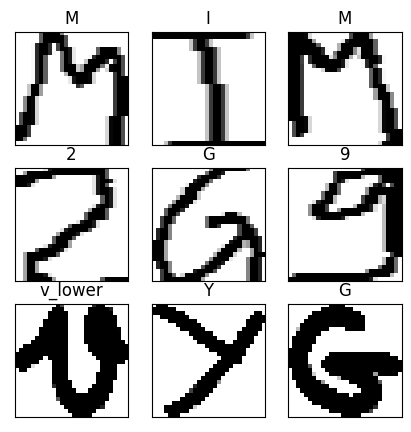

TensorShape([28, 28, 1])

In [ ]:
string_labels = full_dataset.class_names

plt.figure(figsize=(5, 5))
for batch in full_dataset.take(1):
    images, labels = batch
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(string_labels[np.argmax(labels[i])])
        plt.xticks([])
        plt.yticks([])
        
plt.show()

images[i].shape

Now that the data has been imported, we can build the model and train it on this data.

In [ ]:
model = Sequential()
model.add(
    Conv2D(filters=32,
           kernel_size=(3, 3),
           activation='relu',
           input_shape=(28, 28, 1),
           name="conv-1",
           padding="same"))
model.add(
    MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool-1", padding="same"))
model.add(
    Conv2D(filters=64,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name="conv-2"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool-2", padding="same"))
model.add(
    Conv2D(filters=128,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name="conv-3"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool-3", padding="same"))
model.add(Flatten())
model.add(Dense(64, activation="relu", name="dense-1"))
model.add(Dense(128, activation="relu", name="dense-2"))
model.add(Dense(62, activation="softmax", name="dense-3"))

In short, the model has the following architecture:

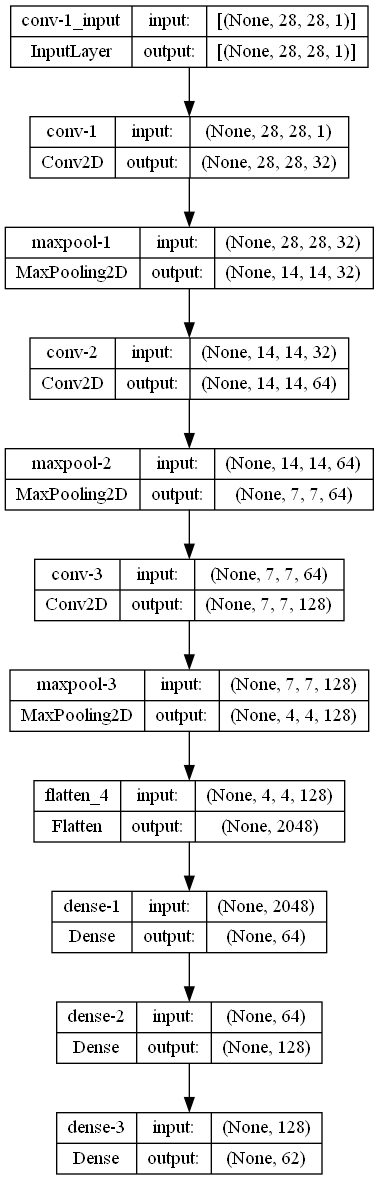

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In summary:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv-1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 maxpool-1 (MaxPooling2D)    (None, 14, 14, 32)        0         
                                                                 
 conv-2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 maxpool-2 (MaxPooling2D)    (None, 7, 7, 64)          0         
                                                                 
 conv-3 (Conv2D)             (None, 7, 7, 128)         73856     
                                                                 
 maxpool-3 (MaxPooling2D)    (None, 4, 4, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 2048)             

Then, we can compile the model. We will use the Adam optimizer algorithm described earlier; we will also use the categorical cross entropy loss.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset , epochs=30)

Epoch 1/30
101/101 [==============================] - 7s 59ms/step - loss: 5.8667 - accuracy: 0.0226 - precision_3: 0.0360 - recall_3: 0.0026 - val_loss: 4.0228 - val_accuracy: 0.0260 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/30
101/101 [==============================] - 6s 62ms/step - loss: 3.6865 - accuracy: 0.0623 - precision_3: 1.0000 - recall_3: 3.0941e-04 - val_loss: 3.0391 - val_accuracy: 0.1276 - val_precision_3: 0.8000 - val_recall_3: 0.0104
Epoch 3/30
101/101 [==============================] - 7s 73ms/step - loss: 2.6899 - accuracy: 0.2155 - precision_3: 0.6177 - recall_3: 0.0312 - val_loss: 2.1177 - val_accuracy: 0.3880 - val_precision_3: 0.7647 - val_recall_3: 0.1354
Epoch 4/30
101/101 [==============================] - 7s 71ms/step - loss: 1.7613 - accuracy: 0.4454 - precision_3: 0.6887 - recall_3: 0.2386 - val_loss: 1.4585 - val_accuracy: 0.5182 - val_precision_3: 0.7449 - val_recall_3: 0.3307
Epoch 5/30
101/101 [==============================] - 7s

In order to evalutate this model, we will plot the graphs of **accuracy, precision, and recall** as a function of the training epochs. We can do so using the *history* object that the *fit* function returns:

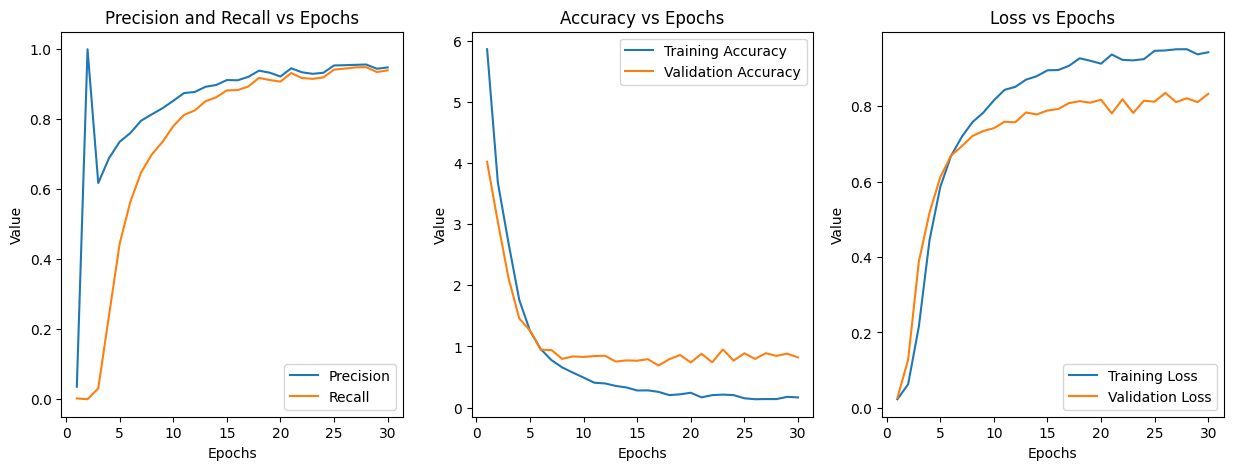

In [ ]:
def plot_acc_loss_pr(train_values, val_values, pr):
    train_acc = train_values[1]
    train_loss = train_values[0]
    val_loss = val_values[0]
    val_acc = val_values[1]
    precision = pr[0]
    recall = pr[1]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, 31), precision, label="Precision")
    plt.plot(range(1, 31), recall, label="Recall")
    plt.title("Precision and Recall vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, 31), train_acc, label="Training Accuracy")
    plt.plot(range(1, 31), val_acc, label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, 31), train_loss, label="Training Loss")
    plt.plot(range(1, 31), val_loss, label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()


pr = history.history["precision_3"], history.history["recall_3"]
train_values = history.history["accuracy"], history.history["loss"]
val_values = history.history["val_accuracy"], history.history["val_loss"]

plot_acc_loss_pr(train_values, val_values, pr)

We will also test the model on the testing set, and report the accuracy.

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_dataset)
print(f"\nTest loss: {results[0]}\nTest Accuracy: {results[1]}")

Evaluate on test data
12/12 [==============================] - 2s 13ms/step - loss: 1.2893 - accuracy: 0.7402 - precision_3: 0.7537 - recall_3: 0.7350

Test loss: 1.2893182039260864
Test Accuracy: 0.7402088642120361


We see that this model achieves an **accuracy of 74%**

### Data Augmentation

From the above graphs, we can clearly see that the model is quickly overfitting: training accuracy reaches really high levels, while validation accuracy starts eventually decreasing. Furthermore, test accuracy is not great.

Our initial hypothesis is that this is happening due to lack of extensive data. Therefore, we will proceed with augmenting the data in order to try and decrease overfitting.

For reference, data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.

In our case, we will be applying the following data augmentation techniques:
* **Random flip:** randomly rotates images during training. We will use a range of [-0.1, 0.1].

We will not use other transformations such as flipping, zooming, and cropping, since these might end up altering the labels of the letters.

In [ ]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomRotation(factor=(-0.05, 0.05)),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's visualize some of these to see the rotations:

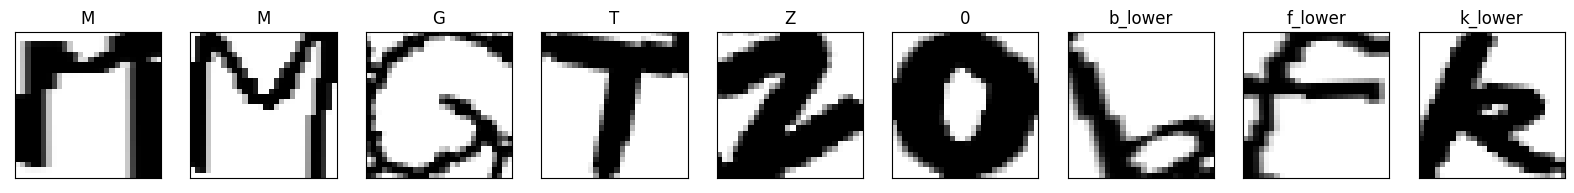

In [ ]:
plt.figure(figsize=(20,30))

images, labels = list(train_dataset.take(1))[0]

for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(string_labels[np.argmax(labels[i])])
    plt.xticks([])
    plt.yticks([])


    

Now we can rerun the training, this time using the augmented dataset.

In [ ]:
model_cloned = tf.keras.models.clone_model(model)
model_cloned.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ])

EPOCHS = 30

history = model_cloned.fit(train_dataset, validation_data=val_dataset , epochs=EPOCHS)

Epoch 1/30
101/101 [==============================] - 9s 82ms/step - loss: 5.1665 - accuracy: 0.0215 - precision_5: 0.0210 - recall_5: 0.0011 - val_loss: 3.9984 - val_accuracy: 0.0430 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/30
101/101 [==============================] - 8s 73ms/step - loss: 3.7639 - accuracy: 0.0650 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 3.4258 - val_accuracy: 0.1354 - val_precision_5: 0.6000 - val_recall_5: 0.0039
Epoch 3/30
101/101 [==============================] - 8s 73ms/step - loss: 2.7661 - accuracy: 0.2452 - precision_5: 0.6163 - recall_5: 0.0701 - val_loss: 1.9717 - val_accuracy: 0.4310 - val_precision_5: 0.5994 - val_recall_5: 0.2630
Epoch 4/30
101/101 [==============================] - 8s 75ms/step - loss: 1.6447 - accuracy: 0.4941 - precision_5: 0.6965 - recall_5: 0.3139 - val_loss: 1.2238 - val_accuracy: 0.6016 - val_precision_5: 0.6945 - val_recall_5: 0.5091
Epoch 5/30
101/101 [==============================] 

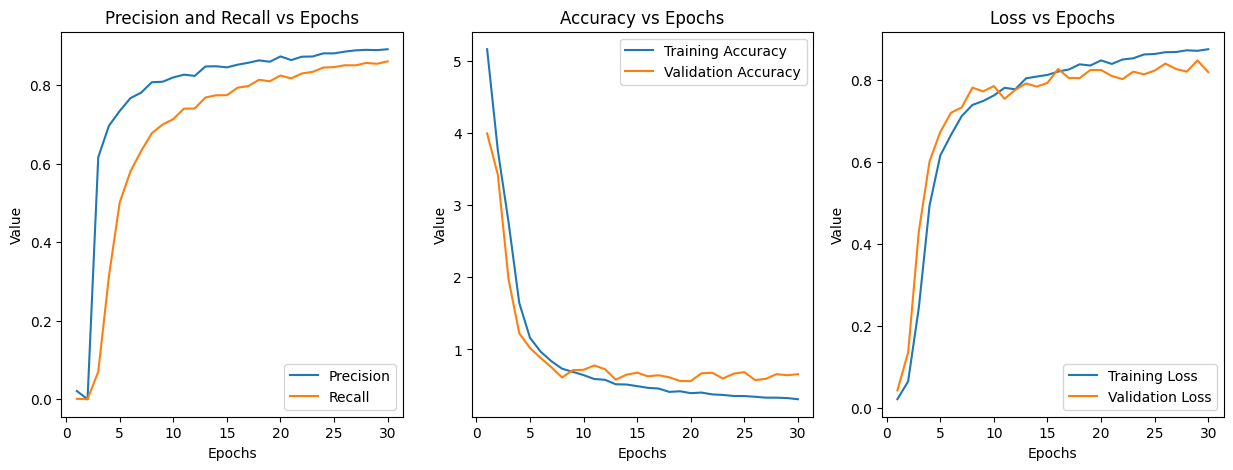

In [ ]:
pr_augmented = history.history["precision_5"], history.history["recall_5"]
train_values_augmented = history.history["accuracy"], history.history["loss"]
val_values_augmented = history.history["val_accuracy"], history.history["val_loss"]

plot_acc_loss_pr(train_values_augmented, val_values_augmented, pr_augmented)

Let's evaluate on the test set:

In [ ]:
print("Evaluate on test data")
results = model_cloned.evaluate(test_dataset)
print(f"\nTest loss: {results[0]}\nTest Accuracy: {results[1]}")

Evaluate on test data
12/12 [==============================] - 2s 13ms/step - loss: 0.8093 - accuracy: 0.7807 - precision_5: 0.7959 - recall_5: 0.7689

Test loss: 0.8093003034591675
Test Accuracy: 0.7806788682937622


We can see that the model has become more resistant to overfitting!

Let's also plot the confusion matrix:

12/12 [==============================] - 2s 12ms/step


<AxesSubplot: >

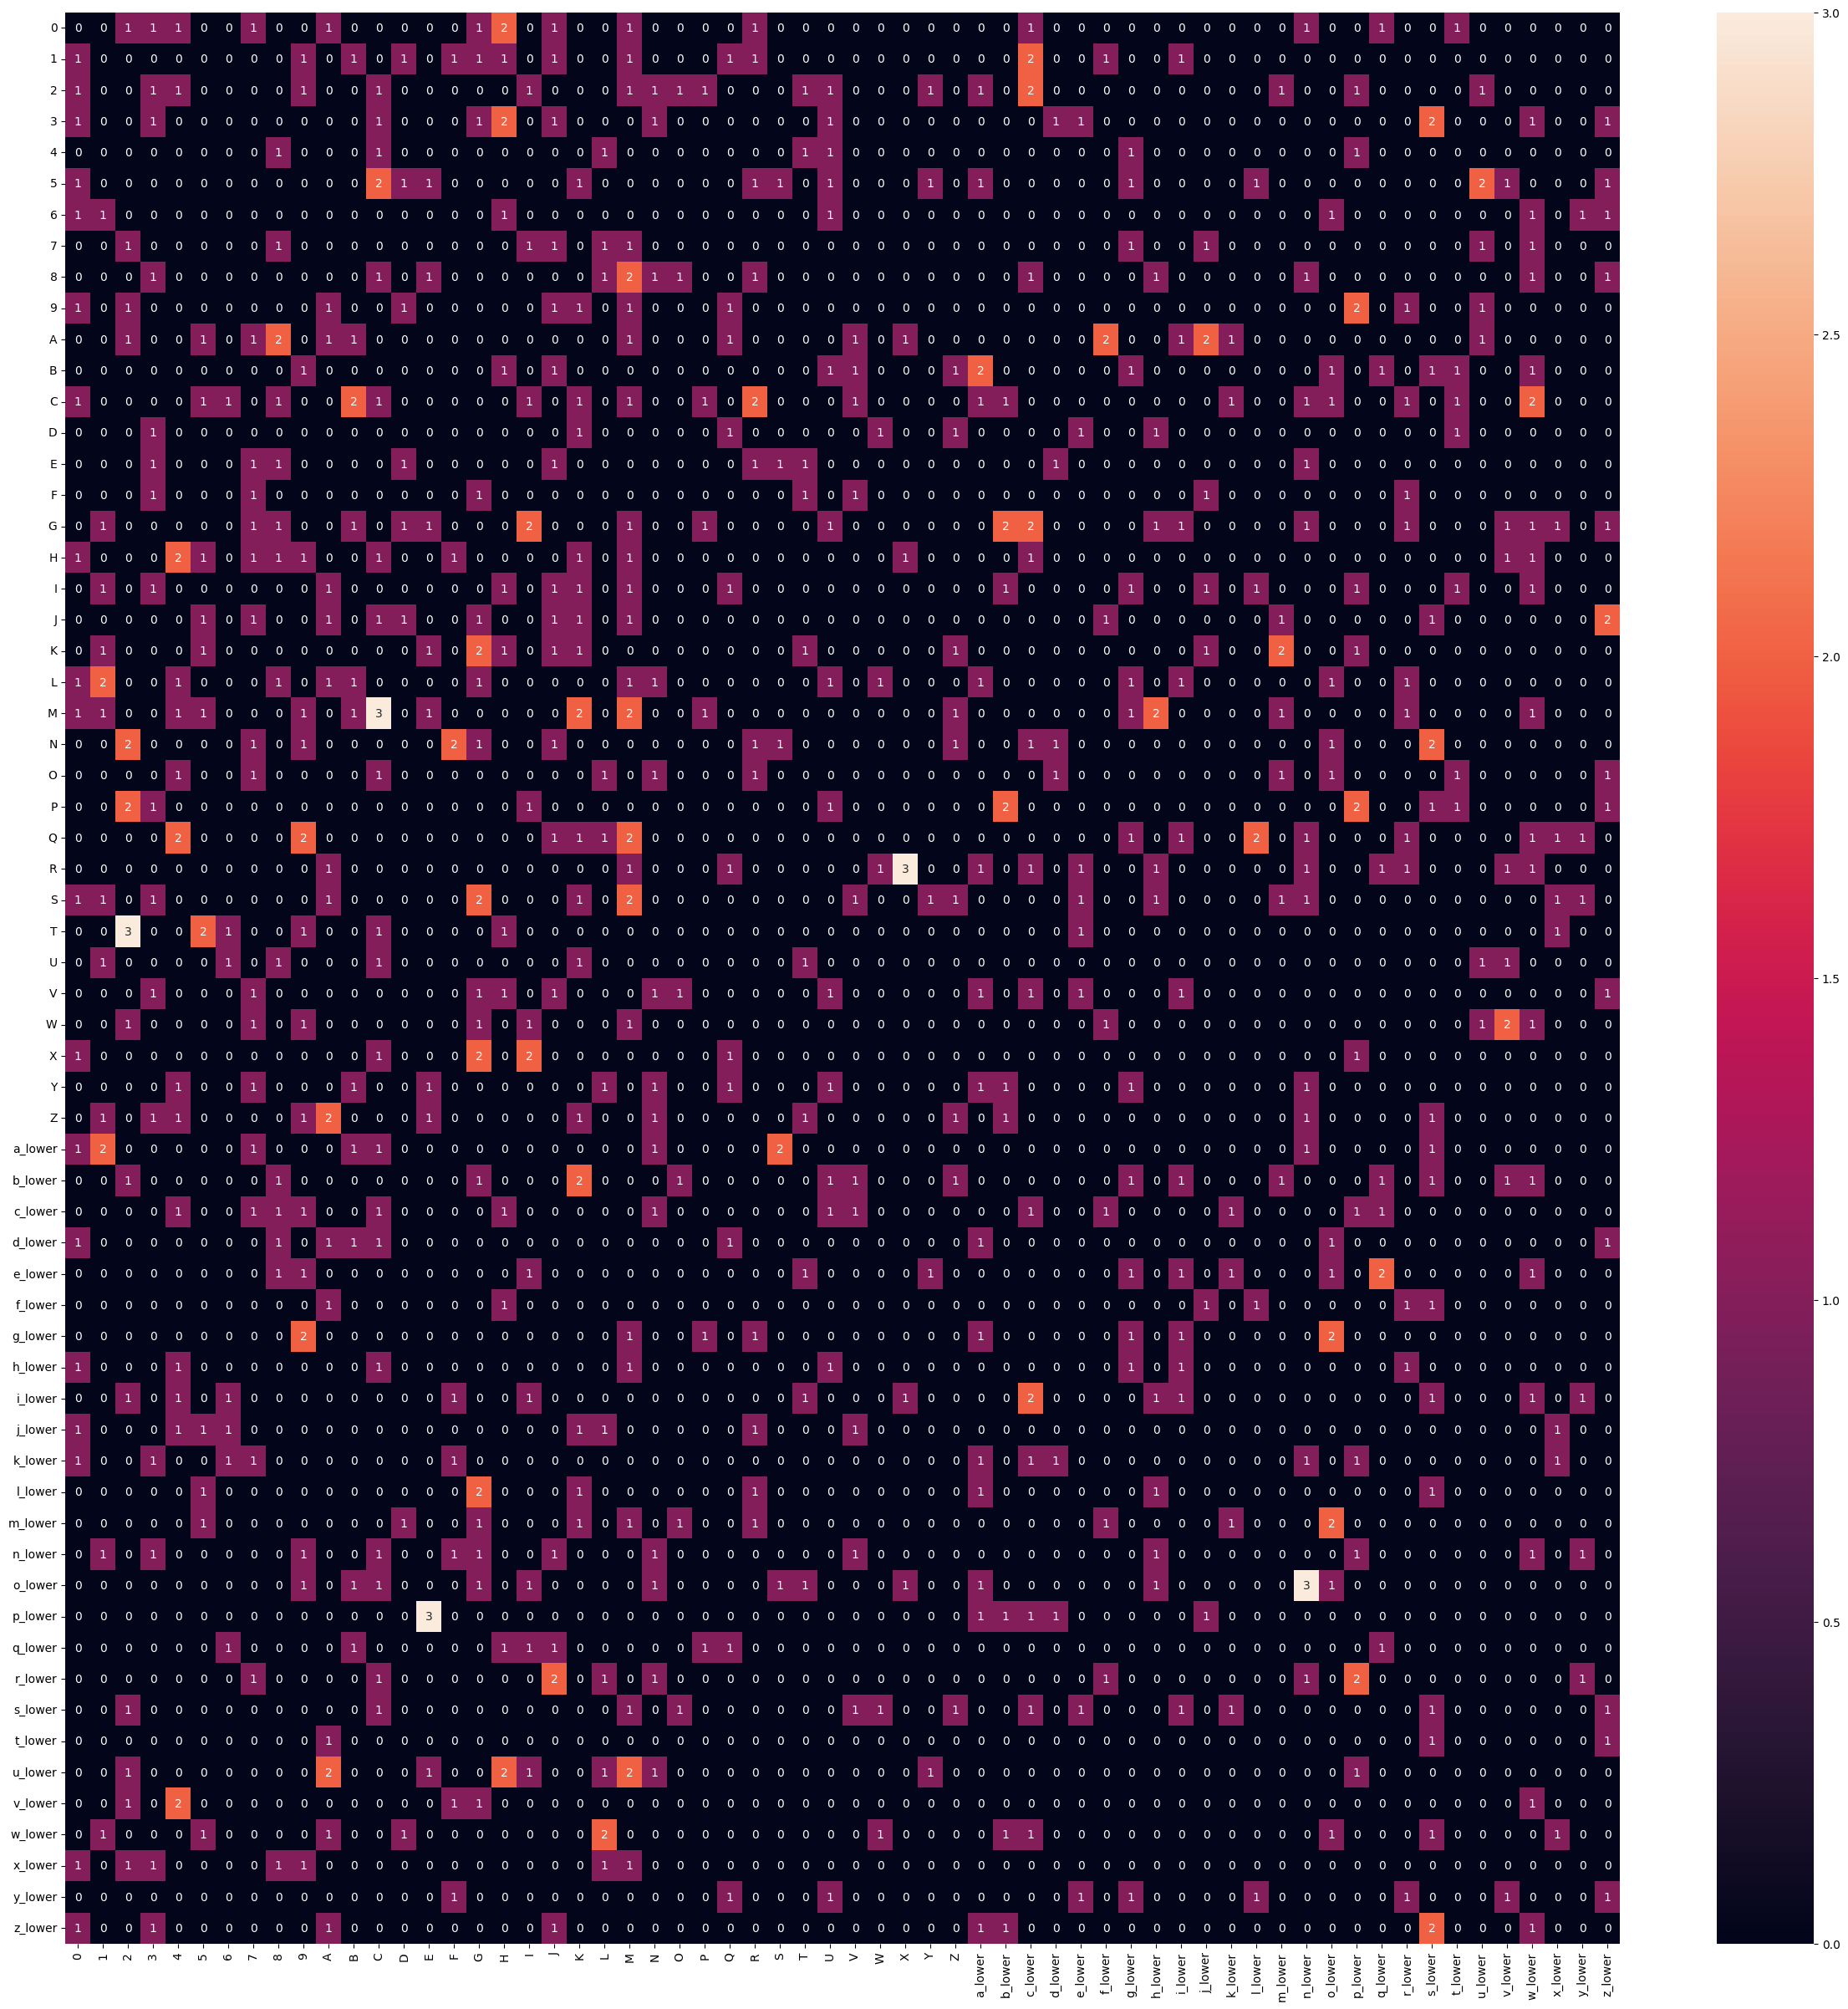

In [ ]:
import seaborn as sn
import tensorflow_datasets as tfds
y = []
x = []

test_dataset_unbatched = test_dataset.unbatch()
#It is a list of tuples, where in each tuple you have a batch of input, then a batch of labels

for image, label in test_dataset_unbatched:
    x.append(image)
    y.append(np.argmax(label))


predictions = model.predict(test_dataset)
predictions = [np.argmax(entry) for entry in predictions]

matrix = tf.math.confusion_matrix(y, predictions, num_classes=62)

df_cm = pd.DataFrame(matrix, index = [i for i in string_labels],
                  columns = [i for i in string_labels])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)


Finally, let's save this model to be able to use it in our note-taking application.

In [ ]:
model_cloned.save('../models/cnn_model')

INFO:tensorflow:Assets written to: ../models/cnn_model\assets


INFO:tensorflow:Assets written to: ../models/cnn_model\assets


### Visualizing Model's Learned Features

To be able to get an insight as to how the model was able to achieve such an accuracy, we will be visualizing the outputs of the intermediate layers. That is, we will try to understand *what the features the model learned look like*.

(28, 28)

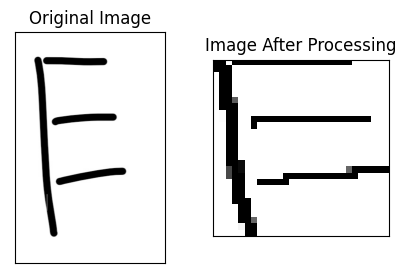

In [ ]:
#Load a test image and preprocess it
original_test = matplotlib.image.imread("../src/test_images/test_10.jpg")
bounded, cropped_test = get_bounding_box("../src/test_images", "test_10.jpg")
test_image = cropped_test[0]

plt.figure(figsize=(5,3))

plt.subplot(1,2,1)
plt.imshow(original_test)
plt.xticks([])
plt.yticks([])
plt.title("Original Image")



plt.subplot(1,2,2)
plt.imshow(test_image, cmap="gray")
plt.xticks([])
plt.yticks([])
_ = plt.title("Image After Processing")

test_image.shape

In [ ]:
test_image = np.array([test_image[:, :, np.newaxis]])
test_image.shape

(1, 28, 28, 1)

In [ ]:
results = model.predict(test_image)
print(string_labels[np.argmax(results)])

1/1 [==============================] - 0s 80ms/step
E


Output of layer shape: (1, 28, 28, 32)


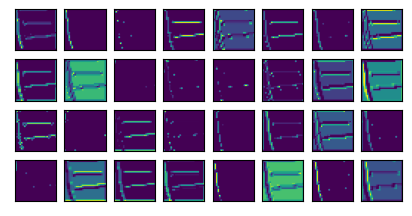

In [ ]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:6]]

activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs)

activations = activation_model.predict(test_image, verbose=0)
  
# Getting Activations of first layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print(f"Output of layer shape: {first_layer_activation.shape}")
  

plt.figure(figsize=(5,2.5))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap="viridis")
    plt.xticks([])
    plt.yticks([])
    
plt.show()

#Transfer Learning <a id='transfer_learning'></a>

### Introduction

What is transfer learning? Trasnfer learning is a machine learning technique where we take a pre-trained model, and modify just enough so it would serve our usecase.

In other words, it re-purposes the model to do something else without going through the time consuming task of training the model from scratch. In general, a pre-trained model can be fine tuned by changing its last few layers and the number of outputs it provides.

In this project, we will be using the VGG-16 pre-trained model availabe on PyTorch. This model is a Convolutional Neural Network that is 16 layers deep. It's architecture can be seen in the following image:

![Image](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

Originally, the VGG-16 model is trained on imagenet to correctly classify 1000 different object. It takes as input a tensor of size (244,244,3). Overall it has a total of 138 million trainable parameters. Training them would take a lot of time. That is why, we will only be training its last few layers that are Fully Connected Layers (or Dense Layers). 

In order to do so, weights freezing must be applied to all the layers we do no wish to train.

### Codes

Importing the modules needed to complete the transfer learning

In [ ]:
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.utils.data
import torchvision.models
from sklearn import metrics 
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from torchsummary import summary
from torch.utils.data import Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

Load the pre-trained model: VGG-16

This model accomodates for 1000 different output (outputted as one-hot encoding). Our model on the other hand can only output 62 different outputs: 26 lowercase letter; 26 uppercase letters; and 10 digits.

This is why, we need to change the last layer of the model and Fine Tune the classifier of the VGG-16 to discern the difference between all 62 classes:

---
* A->Z: 26 classes
* a>z: 26 classes
* 0->9: 10 classes

**Toal of 62 classes**

In [ ]:
model = torchvision.models.vgg16(pretrained=True) 

"""
Change the last layer of the model.classifier
Change its outputs from 1000 to 62
"""
model.classifier = nn.Sequential(
          nn.Linear(in_features=25088, out_features=4096, bias=True),
          nn.ReLU(),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=4096, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=62, bias=True)
        )


"""
Freezing the weights of the Feature part of the VGG-16
But unfreezing the wights of the last layer of the Classifier part 
"""
#model.feature all layers
for parameter in model.features.parameters():
    parameter.requires_grad = False
#model.classifier all layers (except the last one)
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = True

Preparing and Transforming the dataset images to fit the requirements:
> Input of size 224,224,3
> Normalized with:
> >* mean = [0.485, 0.456, 0.406]
> >* standard deviation = [0.229, 0.224, 0.225]

In [ ]:
"""
Normalize/Resize Images for VGG16
"""
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])

resize = transforms.Resize((224, 224))

preprocessor = transforms.Compose([
    resize, 
    transforms.ToTensor(), 
    normalize])

"""
Load Data
""" 
train_dir = './IEA Proj 2/input_pytorch/train' 
test_dir = './IEA Proj 2/input_pytorch/test'

trainset = datasets.ImageFolder(train_dir, preprocessor)
testset = datasets.ImageFolder(test_dir, preprocessor)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

The training method to fine tune the last layer of the model and make it work for handwritten characters

In [ ]:
"""
If any GPU available, make it work on them
Otherwise CPU
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device=='cuda':
     model = model.cuda()


"""
Train the model
"""
def train_model(model, trainloader, criterion, optimizer, epochs, trainsize):
    start_train = time.time()  
    loss = []
    accuracy = []
    epochsX = []
    for epoch in range(epochs):        
        model.train()
        
        epochsX.append(epoch)   

        running_loss = 0.0 
        n_corrects = 0
        # Iterate over data.
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            y_pred = model(inputs)
            loss = criterion(y_pred,labels) 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            n_corrects += (y_pred.argmax(axis=1)==labels).sum().item()               

        loss.append(float(running_loss / (i+1)))
        accuracy.append(float(n_corrects/trainsize))
        print(f'epoch {epoch+1}/{epochs}, loss = {running_loss / (i+1):.4f}, acc = {(n_corrects/trainsize):.4f}%')
        print('-' * 10)

    time_elapsed = time.time() - start_train
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(epochsX, loss)
    ax1.set_title('Loss vs Epochs')
    ax2.scatter(epochsX, accuracy)
    ax2.set_title('Accuracy vs Epochs')

    return model

Now for training the Model

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

finetuned_model = train_model(
    model, 
    train_loader,
    criterion, 
    optimizer,
    10,
    len(train_loader))

In [ ]:
"""
Save fine-tuned model
"""
torch.save(finetuned_model, './models/Finetuned_model')

To test the model, we iterate through train_loader and find the accuracy. Then we plot the confusion matrix

In [ ]:
y_pred = []
y_true = []

for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output = finetuned_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth 
# constant for classes
classes = ('0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z')

#Print Accuracy
values = precision_recall_fscore_support(y_test, y_pred, average = 'macro')
print('Precision: ', values[0])
print('Recall: ', values[1])
print('F-value: ', values[2])
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))

# Build confusion matrix
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes) 
plt.rcParams['figure.figsize'] = (50, 50)
plt.rcParams.update({'font.size': 15})
plt.show()

# Deployment <a id='deployment'></a>

Now that we have developed several models that can be used within the app, we can work on craeting a RESTful API for the app to be able to interact with the model.

To do so, we will be using the FLASK framework available in Python. 

The pipeline will be as follows:

1. User draws something on the Canvas in the app
2. 2s after the last stroke has been made, the app will automatically send a screenshot to the Flask Server
3. The Flask server will run a backend API that pre-processes the input, using the *get_bounding_box* function described earlier 
4. According to the language that was chosen by the user, the Flask server will do a forward pass through one of the pre-trained models discussed in this notebook. 
5. The server will return a string that represents the model's prediction of the drawing. This string will then be processed by the app to be displayed in-app.

The details of this implementation can be found in the code for the app itself. The code for the Flask sever can be found in *api* folder